In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3000


# ANN

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                     'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                     'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                     'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
                     'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                     'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 填充缺失值
df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=True)

# === 2. 构建多输出 ANN 模型 ===
def build_multi_output_ann(input_shape, n_outputs):
    inputs = Input(shape=(input_shape,), name="Input")
    x = Dense(256, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(n_outputs, activation="linear", name="Output")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae"]
    )
    return model

# === 3. 执行多输出模型的10次实验 ===
def run_shared_output_ann(X_train, X_test, y_train, y_test, n_experiments=10):
    results = []
    all_histories = []

    if not os.path.exists("saved_models"):
        os.makedirs("saved_models")

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")
        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_multi_output_ann(X_train.shape[1], y_train.shape[1])

        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time
        all_histories.append(history.history)

        # 模型保存
        model.save(f"saved_models/ann_exp_{i+1}.h5")

        # 预测与反标准化
        start_test = time.time()
        y_pred_scaled = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_real = scaler_y.inverse_transform(y_test)

        for j in range(y_train.shape[1]):
            mae = mean_absolute_error(y_test_real[:, j], y_pred[:, j])
            mse = mean_squared_error(y_test_real[:, j], y_pred[:, j])
            r2 = r2_score(y_test_real[:, j], y_pred[:, j])

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

        # 可视化训练曲线
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Training Curve - Experiment {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"saved_models/loss_curve_exp_{i+1}.png")
        plt.close()

    return pd.DataFrame(results)

# === 4. 执行实验 & 保存结果 ===
experiment_df = run_shared_output_ann(X_train, X_test, y_train, y_test, n_experiments=10)

# 输出或保存
experiment_df.to_csv("multioutput_ann_experiment_results.csv", index=False)
print("Results saved as 'multioutput_ann_experiment_results.csv'")
print(experiment_df)



===== Experiment 1 =====



===== Experiment 2 =====



===== Experiment 3 =====



===== Experiment 4 =====



===== Experiment 5 =====



===== Experiment 6 =====



===== Experiment 7 =====



===== Experiment 8 =====



===== Experiment 9 =====



===== Experiment 10 =====


Results saved as 'multioutput_ann_experiment_results.csv'
    experiment    modulus  train_time  test_time         mae            mse  \
0            1  MODULUS_1   63.725418   0.294209  457.437072  513118.891455   
1            1  MODULUS_2   63.725418   0.294209  317.547900  232260.876666   
2            1  MODULUS_3   63.725418   0.294209    8.028361     121.460529   
3            1  MODULUS_4   63.725418   0.294209    2.930673      15.168591   
4            2  MODULUS_1   64.703860   0.380821  456.137635  489205.285624   
5            2  MODULUS_2   64.703860   0.380821  307.695787  230739.319307   
6            2  MODULUS_3   64.703860   0.380821    8.081365     122.039177   
7            2  MODULUS_4   64.703860   0.380821    2.896095      15.838922   
8            3  MODULUS_1   64.289472   0.366129  450.832670  483881.664472   
9            3  MODULUS_2   64.289472   0.366129  317.812537  231498.095878   
10           3  MODULUS_3   64.289472   0.366129    8.156155     124.1518

# SimpleRNN

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.activations import swish
import matplotlib.pyplot as plt

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled, nan=0)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled, nan=0)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=True)

# Reshape for RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# === 2. 构建 ResRNN-Transformer 单输出层模型（Dense(4)）===
def build_resrnn_transformer(input_shape, output_dim=4):
    input_layer = Input(shape=input_shape)

    x = SimpleRNN(32, return_sequences=True)(input_layer)
    x = BatchNormalization()(x)
    x = SimpleRNN(32)(x)
    x = BatchNormalization()(x)

    x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_expanded, x_expanded)
    attn_output = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_output)
    x = LayerNormalization()(x + attn_output)

    x = Dense(64)(x)
    x = swish(x)

    output = Dense(output_dim, activation='linear', name="modulus_output")(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="mse",
        metrics=["mae"]
    )
    return model

# === 3. 执行10次实验 ===
def run_rnn_with_metrics(X_train, X_test, y_train, y_test, model_name="ResRNN-Transformer", n_experiments=10):
    results = []

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")
        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_resrnn_transformer(input_shape=(X_train.shape[1], 1), output_dim=y_train.shape[1])

        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=64,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred_rnn = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        for j in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, j], y_pred_rnn[:, j])
            mse = mean_squared_error(y_test[:, j], y_pred_rnn[:, j])
            r2 = r2_score(y_test[:, j], y_pred_rnn[:, j])

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

        print(f"Experiment {i+1} Completed: Train Time = {train_time:.2f}s, Test Time = {test_time:.2f}s")

    return results

# === 4. 执行实验并保存结果 ===
experiment_results_rnn = run_rnn_with_metrics(X_train, X_test, y_train, y_test)

experiment_df_rnn = pd.DataFrame(experiment_results_rnn)
experiment_df_rnn.to_csv("experiment_results_rnn.csv", index=False)
print("\nAll experiments completed. Results saved to 'experiment_results_rnn.csv'")
print(experiment_df_rnn)



===== Experiment 1 =====
Experiment 1 Completed: Train Time = 128.92s, Test Time = 0.52s

===== Experiment 2 =====
Experiment 2 Completed: Train Time = 129.61s, Test Time = 0.58s

===== Experiment 3 =====
Experiment 3 Completed: Train Time = 127.46s, Test Time = 0.61s

===== Experiment 4 =====
Experiment 4 Completed: Train Time = 130.82s, Test Time = 0.63s

===== Experiment 5 =====
Experiment 5 Completed: Train Time = 132.14s, Test Time = 0.70s

===== Experiment 6 =====
Experiment 6 Completed: Train Time = 130.66s, Test Time = 0.69s

===== Experiment 7 =====
Experiment 7 Completed: Train Time = 130.17s, Test Time = 1.37s

===== Experiment 8 =====
Experiment 8 Completed: Train Time = 130.97s, Test Time = 0.79s

===== Experiment 9 =====
Experiment 9 Completed: Train Time = 127.60s, Test Time = 0.69s

===== Experiment 10 =====
Experiment 10 Completed: Train Time = 128.40s, Test Time = 0.70s

All experiments completed. Results saved to 'experiment_results_rnn.csv'
    experiment    modulu

# RNN W&D

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, SimpleRNN, MultiHeadAttention, LayerNormalization, Add, BatchNormalization, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

# 标准化
scaler_wide = StandardScaler()
X_wide_scaled = np.nan_to_num(scaler_wide.fit_transform(X_wide))

scaler_deep = StandardScaler()
X_deep_scaled = np.nan_to_num(scaler_deep.fit_transform(X_deep))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep输入 reshape 为 3D
X_deep_scaled_3d = X_deep_scaled.reshape((X_deep_scaled.shape[0], 1, X_deep_scaled.shape[1]))

# 划分数据集
X_deep_train, X_deep_test, X_wide_train, X_wide_test, y_train, y_test = train_test_split(
    X_deep_scaled_3d, X_wide_scaled, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 RNN Wide & Deep + Transformer 模型 ===
def build_rnn_wide_deep_transformer(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    # Wide 分支
    wide_input = Input(shape=(n_wide,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    # Deep 分支（SimpleRNN + Transformer）
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name="deep_input")
    x = SimpleRNN(32, return_sequences=True)(deep_input)
    x = BatchNormalization()(x)
    x = SimpleRNN(32)(x)
    x = BatchNormalization()(x)

    # Transformer Attention Block（结构对齐）
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    # 融合 Wide 和 Deep 分支
    combined = Concatenate()([wide_out, deep_out])
    x = Dense(32, activation="relu")(combined)
    x = Dense(16, activation="relu")(x)

    outputs = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
    return model

# === 3. 执行实验（不保存） ===
def run_experiments(X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n==== Experiment {exp + 1} ====")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_rnn_wide_deep_transformer(
            n_wide=X_wide_train.shape[1],
            n_deep_timesteps=X_deep_train.shape[1],
            n_deep_features=X_deep_train.shape[2],
            n_outputs=y_train.shape[1]
        )

        start_time = time.time()
        model.fit(
            [X_wide_train, X_deep_train],
            y_train,
            validation_data=([X_wide_test, X_deep_test], y_test),
            epochs=100,
            batch_size=64,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])

            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（未保存文件） =====")
    print(df)
    return df

# 执行实验
experiment_df = run_experiments(X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test)



==== Experiment 1 ====

==== Experiment 2 ====

==== Experiment 3 ====

==== Experiment 4 ====

==== Experiment 5 ====

==== Experiment 6 ====

==== Experiment 7 ====

==== Experiment 8 ====

==== Experiment 9 ====

==== Experiment 10 ====

===== 实验完成（未保存文件） =====
    experiment    modulus  train_time  test_time       mae       mse        r2
0            1  MODULUS_1   80.629543   1.358927  0.396109  0.360832  0.644621
1            1  MODULUS_2   80.629543   1.358927  0.337957  0.241000  0.725483
2            1  MODULUS_3   80.629543   1.358927  0.418829  0.331663  0.674631
3            1  MODULUS_4   80.629543   1.358927  0.233489  0.093200  0.906347
4            2  MODULUS_1   77.357527   1.207773  0.384162  0.337667  0.667435
5            2  MODULUS_2   77.357527   1.207773  0.351580  0.261248  0.702420
6            2  MODULUS_3   77.357527   1.207773  0.426477  0.335342  0.671021
7            2  MODULUS_4   77.357527   1.207773  0.243167  0.109710  0.889756
8            3  MODULUS

# RNN+LSTM

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, MultiHeadAttention, LayerNormalization, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# 明确 wide 与 deep 特征列
wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 分别处理特征
Xw = df[wide_columns].copy()
Xd = df[deep_columns].copy()
y = df[target_columns].copy()

# 缺失值处理
Xw = Xw.fillna(Xw.mean(numeric_only=True))
Xd = Xd.fillna(Xd.mean(numeric_only=True))
y = y.fillna(y.mean(numeric_only=True))

# 类别编码（如果有）
for col in Xw.columns:
    if Xw[col].dtype == 'object' or Xw[col].dtype.name == 'category':
        Xw[col] = LabelEncoder().fit_transform(Xw[col])

# 标准化
scaler_wide = StandardScaler()
Xw_scaled = np.nan_to_num(scaler_wide.fit_transform(Xw))

scaler_deep = StandardScaler()
Xd_scaled = np.nan_to_num(scaler_deep.fit_transform(Xd))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep 输入 reshape 为 3D
Xd_scaled_3d = Xd_scaled.reshape((Xd_scaled.shape[0], 1, Xd_scaled.shape[1]))

# 数据集划分
Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test = train_test_split(
    Xw_scaled, Xd_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 Wide & Deep + LSTM + Transformer 模型 ===
def build_wide_deep_lstm_transformer(input_wide_dim, input_deep_shape, n_outputs):
    wide_input = Input(shape=(input_wide_dim,), name="wide_input")
    deep_input = Input(shape=input_deep_shape, name="deep_input")

    # LSTM 层
    x = LSTM(128, return_sequences=True)(deep_input)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)

    # Transformer 部分（自注意力）
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    # 输出层
    deep_out = Dense(64, activation="relu")(x)
    wide_out = Dense(64, activation="relu")(wide_input)

    x = Concatenate()([deep_out, wide_out])
    x = Dense(64, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    output = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行函数 ===
def run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n======== Experiment {exp+1} ========")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_wide_deep_lstm_transformer(
            Xw_train.shape[1], Xd_train.shape[1:], y_train.shape[1]
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1
        )

        start_time = time.time()
        history = model.fit(
            [Xw_train, Xd_train], y_train,
            validation_data=([Xw_test, Xd_test], y_test),
            epochs=50,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )
        train_time = time.time() - start_time
        actual_epochs = len(history.history['loss'])
        print(f"✅ Early stopped at epoch {actual_epochs} | Training time: {train_time:.2f} s")

        start_test = time.time()
        y_pred = model.predict([Xw_test, Xd_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "epochs": actual_epochs,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（含 EarlyStopping 优化） =====")
    print(df)
    return df

# === 4. 执行实验 ===
results_df = run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test)



======== Experiment 1 ========
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 1.0734 - mae: 0.8065 - val_loss: 0.7733 - val_mae: 0.6764
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8026 - mae: 0.6854 - val_loss: 0.6569 - val_mae: 0.6191
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7024 - mae: 0.6396 - val_loss: 0.6121 - val_mae: 0.5950
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6508 - mae: 0.6125 - val_loss: 0.5616 - val_mae: 0.5643
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6055 - mae: 0.5843 - val_loss: 0.5192 - val_mae: 0.5307
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5758 - mae: 0.5607 - val_loss: 0.4989 - val_mae: 0.5139
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5527 - mae: 0.5451 - val_loss: 0.4850 - val_mae: 0.5046
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.5399 - mae: 0.5387 - val_loss: 0.4705 - val_mae: 0.4962
Epoch 9/50
42/42 ━━━━━━━━━━━━━━

# RNN+GRU

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, MultiHeadAttention, LayerNormalization, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model

# === 数据加载 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# 特征与目标
wide_columns = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD',
                'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']
deep_columns = ['PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 缺失值与编码
X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

for col in ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mean())
for col in ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mode()[0])
    X_wide[col] = LabelEncoder().fit_transform(X_wide[col])

X_deep = X_deep.fillna(X_deep.mean())
y = y.fillna(y.mean())

# 标准化
wide_cont = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']
X_wide_scaled = StandardScaler().fit_transform(X_wide[wide_cont])
X_wide_final = np.hstack((X_wide.drop(columns=wide_cont).values, X_wide_scaled))
X_deep_scaled = MinMaxScaler().fit_transform(X_deep)
y_scaled = MinMaxScaler().fit_transform(y)

# 划分训练集
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide_final, X_deep_scaled, y_scaled, test_size=0.2, shuffle=True)

# 调整 deep 为 3D
X_deep_train = X_deep_train.reshape((X_deep_train.shape[0], X_deep_train.shape[1], 1))
X_deep_test = X_deep_test.reshape((X_deep_test.shape[0], X_deep_test.shape[1], 1))

# === 模型构建 ===
def build_model(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    # Wide 输入
    wide_input = Input(shape=(n_wide,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    # Deep 输入：GRU + Transformer
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name="deep_input")
    x = SimpleRNN(64, return_sequences=True)(deep_input)  # 可换成其他结构
    x = GRU(64)(x)
    x = Dropout(0.3)(x)

    # Transformer 部分
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    # 合并
    merged = Concatenate()([wide_out, deep_out])
    merged = Dense(128, activation="relu")(merged)
    output = Dense(n_outputs, activation="linear")(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 实验执行 ===
results = []
for exp in range(10):
    print(f"\n=== Experiment {exp + 1} ===")
    tf.random.set_seed(exp)
    np.random.seed(exp)

    model = build_model(
        n_wide=X_wide_train.shape[1],
        n_deep_timesteps=X_deep_train.shape[1],
        n_deep_features=1,
        n_outputs=y_train.shape[1]
    )

    start_train = time.time()
    model.fit([X_wide_train, X_deep_train], y_train,
              validation_data=([X_wide_test, X_deep_test], y_test),
              epochs=50, batch_size=64, verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)])
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
    test_time = time.time() - start_test

    for i in range(y_test.shape[1]):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])

        results.append({
            "experiment": exp + 1,
            "modulus": f"MODULUS_{i+1}",
            "train_time": train_time,
            "test_time": test_time,
            "mae": mae,
            "mse": mse,
            "r2": r2
        })

# 打印结果（不保存）
results_df = pd.DataFrame(results)
print("\n===== 实验完成（未保存） =====")
print(results_df)



=== Experiment 1 ===

=== Experiment 2 ===

=== Experiment 3 ===

=== Experiment 4 ===

=== Experiment 5 ===

=== Experiment 6 ===

=== Experiment 7 ===

=== Experiment 8 ===

=== Experiment 9 ===

=== Experiment 10 ===

===== 实验完成（未保存） =====
    experiment    modulus  train_time  test_time       mae       mse        r2
0            1  MODULUS_1   46.226203   0.605218  0.081117  0.015445  0.607160
1            1  MODULUS_2   46.226203   0.605218  0.055911  0.006007  0.706862
2            1  MODULUS_3   46.226203   0.605218  0.112289  0.023324  0.626532
3            1  MODULUS_4   46.226203   0.605218  0.055092  0.004846  0.864562
4            2  MODULUS_1   38.533442   1.352816  0.087850  0.015830  0.597367
5            2  MODULUS_2   38.533442   1.352816  0.054477  0.006212  0.696892
6            2  MODULUS_3   38.533442   1.352816  0.114796  0.023819  0.618605
7            2  MODULUS_4   38.533442   1.352816  0.053132  0.004679  0.869236
8            3  MODULUS_1   76.408481   0.691

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, MultiHeadAttention, LayerNormalization, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理（对齐 LSTM）===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# Wide & Deep 特征列（与 LSTM 保持一致）
wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 提取数据
Xw = df[wide_columns].copy()
Xd = df[deep_columns].copy()
y = df[target_columns].copy()

# 缺失值处理
Xw = Xw.fillna(Xw.mean(numeric_only=True))
Xd = Xd.fillna(Xd.mean(numeric_only=True))
y = y.fillna(y.mean(numeric_only=True))

# 类别编码（如有）
for col in Xw.columns:
    if Xw[col].dtype == 'object' or Xw[col].dtype.name == 'category':
        Xw[col] = LabelEncoder().fit_transform(Xw[col])

# 标准化处理
scaler_wide = StandardScaler()
Xw_scaled = np.nan_to_num(scaler_wide.fit_transform(Xw))

scaler_deep = StandardScaler()
Xd_scaled = np.nan_to_num(scaler_deep.fit_transform(Xd))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep 输入 reshape 为 3D
Xd_scaled_3d = Xd_scaled.reshape((Xd_scaled.shape[0], 1, Xd_scaled.shape[1]))

# 数据划分（test_size 设为 0.3）
Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test = train_test_split(
    Xw_scaled, Xd_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 GRU 模型（结构与命名统一）===
def build_wide_deep_gru_transformer(input_wide_dim, input_deep_shape, n_outputs):
    wide_input = Input(shape=(input_wide_dim,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    deep_input = Input(shape=input_deep_shape, name="deep_input")
    x = SimpleRNN(64, return_sequences=True)(deep_input)
    x = GRU(64)(x)
    x = Dropout(0.3)(x)

    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    x = Concatenate()([wide_out, deep_out])
    x = Dense(128, activation="relu")(x)
    output = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行（与 LSTM 完全统一）===
def run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n======== Experiment {exp+1} ========")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_wide_deep_gru_transformer(
            input_wide_dim=Xw_train.shape[1],
            input_deep_shape=Xd_train.shape[1:],
            n_outputs=y_train.shape[1]
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1
        )

        start_time = time.time()
        history = model.fit(
            [Xw_train, Xd_train], y_train,
            validation_data=([Xw_test, Xd_test], y_test),
            epochs=50,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )
        train_time = time.time() - start_time
        actual_epochs = len(history.history['loss'])
        print(f"✅ Early stopped at epoch {actual_epochs} | Training time: {train_time:.2f} s")

        start_test = time.time()
        y_pred = model.predict([Xw_test, Xd_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "epochs": actual_epochs,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（RNN W&D + GRU） =====")
    print(df)
    return df

# === 4. 执行实验 ===
results_df = run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test)



======== Experiment 1 ========
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 0.7860 - mae: 0.6755 - val_loss: 0.4233 - val_mae: 0.4749
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4716 - mae: 0.4979 - val_loss: 0.3649 - val_mae: 0.4345
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.4144 - mae: 0.4616 - val_loss: 0.3238 - val_mae: 0.3996
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3860 - mae: 0.4419 - val_loss: 0.3124 - val_mae: 0.3900
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3667 - mae: 0.4286 - val_loss: 0.2988 - val_mae: 0.3757
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3617 - mae: 0.4204 - val_loss: 0.2961 - val_mae: 0.3740
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3489 - mae: 0.4126 - val_loss: 0.2843 - val_mae: 0.3668
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3391 - mae: 0.4053 - val_loss: 0.2792 - val_mae: 0.3585
Epoch 9/50
42/42 ━━━━━━━━━━━━━━

# RNN+gru+lstm

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, MultiHeadAttention, LayerNormalization, Add, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

wide_columns = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD',
                'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']
deep_columns = ['PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

wide_continuous = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']
wide_categorical = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']

# 缺失值填补
for col in wide_continuous:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mean())
for col in wide_categorical:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mode()[0])
X_deep = X_deep.fillna(X_deep.mean())
y = y.fillna(y.mean())

# 编码分类特征
for col in wide_categorical:
    le = LabelEncoder()
    X_wide[col] = le.fit_transform(X_wide[col])

# 特征缩放
scaler_wide = StandardScaler()
X_wide_cont = scaler_wide.fit_transform(X_wide[wide_continuous])
X_wide_final = np.hstack([X_wide[wide_categorical], X_wide_cont])

scaler_deep = MinMaxScaler()
X_deep_scaled = scaler_deep.fit_transform(X_deep)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# reshape Deep 为 3D
X_deep_scaled_3d = X_deep_scaled.reshape((X_deep_scaled.shape[0], X_deep_scaled.shape[1], 1))

# === 数据划分：训练70%，测试30% ===
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide_final, X_deep_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 模型构建函数 ===
def build_model(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    wide_input = Input(shape=(n_wide,), name='wide_input')
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name='deep_input')

    # === Wide 分支 ===
    wide_out = Dense(64, activation="relu")(wide_input)

    # === Deep 分支：SimpleRNN ➜ LSTM ➜ GRU + 残差连接 ===
    x = SimpleRNN(64, return_sequences=True)(deep_input)
    x = LayerNormalization()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LayerNormalization()(x)
    x = GRU(64)(x)

    x_residual = Dense(64, activation="relu")(x)
    x = Add()([x, x_residual])  # 残差连接
    x = Dropout(0.3)(x)

    # === Transformer模块 ===
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn = Lambda(lambda t: tf.squeeze(t, axis=1))(attn)
    x = LayerNormalization()(x + attn)

    deep_out = Dense(64, activation="relu")(x)

    # === 融合 Wide & Deep ===
    merged = Concatenate()([wide_out, deep_out])
    merged = Dense(64, activation="relu")(merged)
    output = Dense(n_outputs, activation="linear")(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行 ===
results = []
for exp in range(10):
    print(f"\n=== Experiment {exp + 1} ===")
    tf.random.set_seed(exp)
    np.random.seed(exp)

    model = build_model(
        n_wide=X_wide_train.shape[1],
        n_deep_timesteps=X_deep_train.shape[1],
        n_deep_features=X_deep_train.shape[2],
        n_outputs=y_train.shape[1]
    )

    start_train = time.time()
    model.fit([X_wide_train, X_deep_train], y_train,
              validation_data=([X_wide_test, X_deep_test], y_test),
              epochs=50, batch_size=64, verbose=0)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
    test_time = time.time() - start_test

    for i in range(y_test.shape[1]):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        results.append({
            "experiment": exp + 1,
            "modulus": f"MODULUS_{i+1}",
            "train_time": train_time,
            "test_time": test_time,
            "epochs": 50,
            "mae": mae,
            "mse": mse,
            "r2": r2
        })

# === 4. 打印结果 ===
results_df = pd.DataFrame(results)
print("\n===== 实验完成（RNN结构: SimpleRNN ➜ LSTM ➜ GRU + 残差）=====")
print(results_df)


=== Experiment 1 ===

=== Experiment 2 ===

=== Experiment 3 ===

=== Experiment 4 ===

=== Experiment 5 ===

=== Experiment 6 ===

=== Experiment 7 ===

=== Experiment 8 ===

=== Experiment 9 ===

=== Experiment 10 ===

===== 实验完成（RNN结构: SimpleRNN ➜ LSTM ➜ GRU + 残差）=====
    experiment    modulus  train_time  test_time  epochs       mae       mse  \
0            1  MODULUS_1  119.190112   1.612819      50  0.081752  0.014940   
1            1  MODULUS_2  119.190112   1.612819      50  0.060645  0.006963   
2            1  MODULUS_3  119.190112   1.612819      50  0.111032  0.021630   
3            1  MODULUS_4  119.190112   1.612819      50  0.052519  0.004525   
4            2  MODULUS_1  122.418059   2.662012      50  0.081532  0.014796   
5            2  MODULUS_2  122.418059   2.662012      50  0.059297  0.006999   
6            2  MODULUS_3  122.418059   2.662012      50  0.110619  0.021546   
7            2  MODULUS_4  122.418059   2.662012      50  0.065974  0.006979   
8     

# 6000

# ann

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                     'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                     'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                     'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
                     'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                     'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 填充缺失值
df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=True)

# === 2. 构建多输出 ANN 模型 ===
def build_multi_output_ann(input_shape, n_outputs):
    inputs = Input(shape=(input_shape,), name="Input")
    x = Dense(256, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(n_outputs, activation="linear", name="Output")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae"]
    )
    return model

# === 3. 执行多输出模型的10次实验 ===
def run_shared_output_ann(X_train, X_test, y_train, y_test, n_experiments=10):
    results = []
    all_histories = []

    if not os.path.exists("saved_models"):
        os.makedirs("saved_models")

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")
        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_multi_output_ann(X_train.shape[1], y_train.shape[1])

        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time
        all_histories.append(history.history)

        # 模型保存
        model.save(f"saved_models/ann_exp_{i+1}.h5")

        # 预测与反标准化
        start_test = time.time()
        y_pred_scaled = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_test_real = scaler_y.inverse_transform(y_test)

        for j in range(y_train.shape[1]):
            mae = mean_absolute_error(y_test_real[:, j], y_pred[:, j])
            mse = mean_squared_error(y_test_real[:, j], y_pred[:, j])
            r2 = r2_score(y_test_real[:, j], y_pred[:, j])

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

        # 可视化训练曲线
        plt.figure(figsize=(8, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'Training Curve - Experiment {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"saved_models/loss_curve_exp_{i+1}.png")
        plt.close()

    return pd.DataFrame(results)

# === 4. 执行实验 & 保存结果 ===
experiment_df = run_shared_output_ann(X_train, X_test, y_train, y_test, n_experiments=10)

# 输出或保存
experiment_df.to_csv("multioutput_ann_experiment_results.csv", index=False)
print("Results saved as 'multioutput_ann_experiment_results.csv'")
print(experiment_df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx'

# SimpleRNN

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.activations import swish
import matplotlib.pyplot as plt

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled, nan=0)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled, nan=0)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=True)

# Reshape for RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# === 2. 构建 ResRNN-Transformer 单输出层模型（Dense(4)）===
def build_resrnn_transformer(input_shape, output_dim=4):
    input_layer = Input(shape=input_shape)

    x = SimpleRNN(32, return_sequences=True)(input_layer)
    x = BatchNormalization()(x)
    x = SimpleRNN(32)(x)
    x = BatchNormalization()(x)

    x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=16)(x_expanded, x_expanded)
    attn_output = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_output)
    x = LayerNormalization()(x + attn_output)

    x = Dense(64)(x)
    x = swish(x)

    output = Dense(output_dim, activation='linear', name="modulus_output")(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="mse",
        metrics=["mae"]
    )
    return model

# === 3. 执行10次实验 ===
def run_rnn_with_metrics(X_train, X_test, y_train, y_test, model_name="ResRNN-Transformer", n_experiments=10):
    results = []

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")
        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_resrnn_transformer(input_shape=(X_train.shape[1], 1), output_dim=y_train.shape[1])

        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=64,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred_rnn = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        for j in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, j], y_pred_rnn[:, j])
            mse = mean_squared_error(y_test[:, j], y_pred_rnn[:, j])
            r2 = r2_score(y_test[:, j], y_pred_rnn[:, j])

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

        print(f"Experiment {i+1} Completed: Train Time = {train_time:.2f}s, Test Time = {test_time:.2f}s")

    return results

# === 4. 执行实验并保存结果 ===
experiment_results_rnn = run_rnn_with_metrics(X_train, X_test, y_train, y_test)

experiment_df_rnn = pd.DataFrame(experiment_results_rnn)
experiment_df_rnn.to_csv("experiment_results_rnn.csv", index=False)
print("\nAll experiments completed. Results saved to 'experiment_results_rnn.csv'")
print(experiment_df_rnn)



===== Experiment 1 =====
Experiment 1 Completed: Train Time = 206.94s, Test Time = 1.20s

===== Experiment 2 =====
Experiment 2 Completed: Train Time = 222.15s, Test Time = 1.04s

===== Experiment 3 =====
Experiment 3 Completed: Train Time = 216.50s, Test Time = 1.35s

===== Experiment 4 =====
Experiment 4 Completed: Train Time = 224.11s, Test Time = 2.64s

===== Experiment 5 =====
Experiment 5 Completed: Train Time = 283.12s, Test Time = 1.28s

===== Experiment 6 =====
Experiment 6 Completed: Train Time = 288.45s, Test Time = 2.68s

===== Experiment 7 =====
Experiment 7 Completed: Train Time = 252.74s, Test Time = 1.34s

===== Experiment 8 =====
Experiment 8 Completed: Train Time = 239.63s, Test Time = 2.63s

===== Experiment 9 =====
Experiment 9 Completed: Train Time = 237.09s, Test Time = 1.20s

===== Experiment 10 =====
Experiment 10 Completed: Train Time = 238.96s, Test Time = 1.35s

All experiments completed. Results saved to 'experiment_results_rnn.csv'
    experiment    modulu

# RNN W&D

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, SimpleRNN, MultiHeadAttention, LayerNormalization, Add, BatchNormalization, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

# 标准化
scaler_wide = StandardScaler()
X_wide_scaled = np.nan_to_num(scaler_wide.fit_transform(X_wide))

scaler_deep = StandardScaler()
X_deep_scaled = np.nan_to_num(scaler_deep.fit_transform(X_deep))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep输入 reshape 为 3D
X_deep_scaled_3d = X_deep_scaled.reshape((X_deep_scaled.shape[0], 1, X_deep_scaled.shape[1]))

# 划分数据集
X_deep_train, X_deep_test, X_wide_train, X_wide_test, y_train, y_test = train_test_split(
    X_deep_scaled_3d, X_wide_scaled, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 RNN Wide & Deep + Transformer 模型 ===
def build_rnn_wide_deep_transformer(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    # Wide 分支
    wide_input = Input(shape=(n_wide,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    # Deep 分支（SimpleRNN + Transformer）
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name="deep_input")
    x = SimpleRNN(32, return_sequences=True)(deep_input)
    x = BatchNormalization()(x)
    x = SimpleRNN(32)(x)
    x = BatchNormalization()(x)

    # Transformer Attention Block（结构对齐）
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    # 融合 Wide 和 Deep 分支
    combined = Concatenate()([wide_out, deep_out])
    x = Dense(32, activation="relu")(combined)
    x = Dense(16, activation="relu")(x)

    outputs = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
    return model

# === 3. 执行实验（不保存） ===
def run_experiments(X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n==== Experiment {exp + 1} ====")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_rnn_wide_deep_transformer(
            n_wide=X_wide_train.shape[1],
            n_deep_timesteps=X_deep_train.shape[1],
            n_deep_features=X_deep_train.shape[2],
            n_outputs=y_train.shape[1]
        )

        start_time = time.time()
        model.fit(
            [X_wide_train, X_deep_train],
            y_train,
            validation_data=([X_wide_test, X_deep_test], y_test),
            epochs=100,
            batch_size=64,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)]
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])

            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（未保存文件） =====")
    print(df)
    return df

# 执行实验
experiment_df = run_experiments(X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test)



==== Experiment 1 ====

==== Experiment 2 ====

==== Experiment 3 ====

==== Experiment 4 ====

==== Experiment 5 ====

==== Experiment 6 ====

==== Experiment 7 ====

==== Experiment 8 ====

==== Experiment 9 ====

==== Experiment 10 ====

===== 实验完成（未保存文件） =====
    experiment    modulus  train_time  test_time       mae       mse        r2
0            1  MODULUS_1  131.279454   1.308904  0.065114  0.010761  0.989437
1            1  MODULUS_2  131.279454   1.308904  0.059675  0.008976  0.989867
2            1  MODULUS_3  131.279454   1.308904  0.111795  0.036679  0.961285
3            1  MODULUS_4  131.279454   1.308904  0.051921  0.004840  0.989591
4            2  MODULUS_1  123.830023   1.168515  0.054272  0.007626  0.992515
5            2  MODULUS_2  123.830023   1.168515  0.057866  0.009110  0.989717
6            2  MODULUS_3  123.830023   1.168515  0.100584  0.034492  0.963594
7            2  MODULUS_4  123.830023   1.168515  0.048110  0.004252  0.990856
8            3  MODULUS

# RNN+LSTM

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate, MultiHeadAttention, LayerNormalization, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# 明确 wide 与 deep 特征列
wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 分别处理特征
Xw = df[wide_columns].copy()
Xd = df[deep_columns].copy()
y = df[target_columns].copy()

# 缺失值处理
Xw = Xw.fillna(Xw.mean(numeric_only=True))
Xd = Xd.fillna(Xd.mean(numeric_only=True))
y = y.fillna(y.mean(numeric_only=True))

# 类别编码（如果有）
for col in Xw.columns:
    if Xw[col].dtype == 'object' or Xw[col].dtype.name == 'category':
        Xw[col] = LabelEncoder().fit_transform(Xw[col])

# 标准化
scaler_wide = StandardScaler()
Xw_scaled = np.nan_to_num(scaler_wide.fit_transform(Xw))

scaler_deep = StandardScaler()
Xd_scaled = np.nan_to_num(scaler_deep.fit_transform(Xd))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep 输入 reshape 为 3D
Xd_scaled_3d = Xd_scaled.reshape((Xd_scaled.shape[0], 1, Xd_scaled.shape[1]))

# 数据集划分
Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test = train_test_split(
    Xw_scaled, Xd_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 Wide & Deep + LSTM + Transformer 模型 ===
def build_wide_deep_lstm_transformer(input_wide_dim, input_deep_shape, n_outputs):
    wide_input = Input(shape=(input_wide_dim,), name="wide_input")
    deep_input = Input(shape=input_deep_shape, name="deep_input")

    # LSTM 层
    x = LSTM(128, return_sequences=True)(deep_input)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)

    # Transformer 部分（自注意力）
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    # 输出层
    deep_out = Dense(64, activation="relu")(x)
    wide_out = Dense(64, activation="relu")(wide_input)

    x = Concatenate()([deep_out, wide_out])
    x = Dense(64, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    output = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行函数 ===
def run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n======== Experiment {exp+1} ========")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_wide_deep_lstm_transformer(
            Xw_train.shape[1], Xd_train.shape[1:], y_train.shape[1]
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1
        )

        start_time = time.time()
        history = model.fit(
            [Xw_train, Xd_train], y_train,
            validation_data=([Xw_test, Xd_test], y_test),
            epochs=50,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )
        train_time = time.time() - start_time
        actual_epochs = len(history.history['loss'])
        print(f"✅ Early stopped at epoch {actual_epochs} | Training time: {train_time:.2f} s")

        start_test = time.time()
        y_pred = model.predict([Xw_test, Xd_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "epochs": actual_epochs,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（含 EarlyStopping 优化） =====")
    print(df)
    return df

# === 4. 执行实验 ===
results_df = run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test)



======== Experiment 1 ========
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.9290 - mae: 0.6659 - val_loss: 0.4733 - val_mae: 0.4831
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6027 - mae: 0.4698 - val_loss: 0.2864 - val_mae: 0.3442
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.4414 - mae: 0.3557 - val_loss: 0.2423 - val_mae: 0.2983
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.3933 - mae: 0.3192 - val_loss: 0.2195 - val_mae: 0.2838
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3626 - mae: 0.2993 - val_loss: 0.1953 - val_mae: 0.2640
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3367 - mae: 0.2859 - val_loss: 0.1742 - val_mae: 0.2427
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3067 - mae: 0.2638 - val_loss: 0.1575 - val_mae: 0.2275
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2907 - mae: 0.2529 - val_loss: 0.1447 - val_mae: 0.2143
Epoch 9/50
72/72 ━━━━━━━━━━━━━━

# RNN+GRU

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, MultiHeadAttention, LayerNormalization, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model

# === 数据加载 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# 特征与目标
wide_columns = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD',
                'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']
deep_columns = ['PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 缺失值与编码
X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

for col in ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mean())
for col in ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mode()[0])
    X_wide[col] = LabelEncoder().fit_transform(X_wide[col])

X_deep = X_deep.fillna(X_deep.mean())
y = y.fillna(y.mean())

# 标准化
wide_cont = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']
X_wide_scaled = StandardScaler().fit_transform(X_wide[wide_cont])
X_wide_final = np.hstack((X_wide.drop(columns=wide_cont).values, X_wide_scaled))
X_deep_scaled = MinMaxScaler().fit_transform(X_deep)
y_scaled = MinMaxScaler().fit_transform(y)

# 划分训练集
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide_final, X_deep_scaled, y_scaled, test_size=0.2, shuffle=True)

# 调整 deep 为 3D
X_deep_train = X_deep_train.reshape((X_deep_train.shape[0], X_deep_train.shape[1], 1))
X_deep_test = X_deep_test.reshape((X_deep_test.shape[0], X_deep_test.shape[1], 1))

# === 模型构建 ===
def build_model(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    # Wide 输入
    wide_input = Input(shape=(n_wide,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    # Deep 输入：GRU + Transformer
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name="deep_input")
    x = SimpleRNN(64, return_sequences=True)(deep_input)  # 可换成其他结构
    x = GRU(64)(x)
    x = Dropout(0.3)(x)

    # Transformer 部分
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    # 合并
    merged = Concatenate()([wide_out, deep_out])
    merged = Dense(128, activation="relu")(merged)
    output = Dense(n_outputs, activation="linear")(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 实验执行 ===
results = []
for exp in range(10):
    print(f"\n=== Experiment {exp + 1} ===")
    tf.random.set_seed(exp)
    np.random.seed(exp)

    model = build_model(
        n_wide=X_wide_train.shape[1],
        n_deep_timesteps=X_deep_train.shape[1],
        n_deep_features=1,
        n_outputs=y_train.shape[1]
    )

    start_train = time.time()
    model.fit([X_wide_train, X_deep_train], y_train,
              validation_data=([X_wide_test, X_deep_test], y_test),
              epochs=50, batch_size=64, verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)])
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
    test_time = time.time() - start_test

    for i in range(y_test.shape[1]):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])

        results.append({
            "experiment": exp + 1,
            "modulus": f"MODULUS_{i+1}",
            "train_time": train_time,
            "test_time": test_time,
            "mae": mae,
            "mse": mse,
            "r2": r2
        })

# 打印结果（不保存）
results_df = pd.DataFrame(results)
print("\n===== 实验完成（未保存） =====")
print(results_df)



=== Experiment 1 ===

=== Experiment 2 ===

=== Experiment 3 ===

=== Experiment 4 ===

=== Experiment 5 ===

=== Experiment 6 ===

=== Experiment 7 ===

=== Experiment 8 ===

=== Experiment 9 ===

=== Experiment 10 ===

===== 实验完成（未保存） =====
    experiment    modulus  train_time  test_time       mae       mse        r2
0            1  MODULUS_1   88.934000   1.755388  0.016119  0.000685  0.992215
1            1  MODULUS_2   88.934000   1.755388  0.010641  0.000424  0.943294
2            1  MODULUS_3   88.934000   1.755388  0.016855  0.000967  0.968777
3            1  MODULUS_4   88.934000   1.755388  0.005115  0.000048  0.961666
4            2  MODULUS_1  102.821518   1.304310  0.012470  0.000436  0.995038
5            2  MODULUS_2  102.821518   1.304310  0.008108  0.000320  0.957149
6            2  MODULUS_3  102.821518   1.304310  0.017475  0.000922  0.970235
7            2  MODULUS_4  102.821518   1.304310  0.004337  0.000032  0.974189
8            3  MODULUS_1  132.713403   2.677

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, MultiHeadAttention, LayerNormalization, Concatenate, Lambda, Dropout
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理（对齐 LSTM）===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# Wide & Deep 特征列（与 LSTM 保持一致）
wide_columns = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
deep_columns = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 提取数据
Xw = df[wide_columns].copy()
Xd = df[deep_columns].copy()
y = df[target_columns].copy()

# 缺失值处理
Xw = Xw.fillna(Xw.mean(numeric_only=True))
Xd = Xd.fillna(Xd.mean(numeric_only=True))
y = y.fillna(y.mean(numeric_only=True))

# 类别编码（如有）
for col in Xw.columns:
    if Xw[col].dtype == 'object' or Xw[col].dtype.name == 'category':
        Xw[col] = LabelEncoder().fit_transform(Xw[col])

# 标准化处理
scaler_wide = StandardScaler()
Xw_scaled = np.nan_to_num(scaler_wide.fit_transform(Xw))

scaler_deep = StandardScaler()
Xd_scaled = np.nan_to_num(scaler_deep.fit_transform(Xd))

scaler_y = StandardScaler()
y_scaled = np.nan_to_num(scaler_y.fit_transform(y))

# Deep 输入 reshape 为 3D
Xd_scaled_3d = Xd_scaled.reshape((Xd_scaled.shape[0], 1, Xd_scaled.shape[1]))

# 数据划分（test_size 设为 0.3）
Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test = train_test_split(
    Xw_scaled, Xd_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 构建 GRU 模型（结构与命名统一）===
def build_wide_deep_gru_transformer(input_wide_dim, input_deep_shape, n_outputs):
    wide_input = Input(shape=(input_wide_dim,), name="wide_input")
    wide_out = Dense(64, activation="relu")(wide_input)

    deep_input = Input(shape=input_deep_shape, name="deep_input")
    x = SimpleRNN(64, return_sequences=True)(deep_input)
    x = GRU(64)(x)
    x = Dropout(0.3)(x)

    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn_out = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_out)
    x = LayerNormalization()(x + attn_out)

    deep_out = Dense(64, activation="relu")(x)

    x = Concatenate()([wide_out, deep_out])
    x = Dense(128, activation="relu")(x)
    output = Dense(n_outputs, activation="linear")(x)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行（与 LSTM 完全统一）===
def run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test, n_experiments=10):
    results = []

    for exp in range(n_experiments):
        print(f"\n======== Experiment {exp+1} ========")
        tf.random.set_seed(exp)
        np.random.seed(exp)

        model = build_wide_deep_gru_transformer(
            input_wide_dim=Xw_train.shape[1],
            input_deep_shape=Xd_train.shape[1:],
            n_outputs=y_train.shape[1]
        )

        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            min_delta=1e-4,
            restore_best_weights=True,
            verbose=1
        )

        start_time = time.time()
        history = model.fit(
            [Xw_train, Xd_train], y_train,
            validation_data=([Xw_test, Xd_test], y_test),
            epochs=50,
            batch_size=64,
            callbacks=[early_stop],
            verbose=1
        )
        train_time = time.time() - start_time
        actual_epochs = len(history.history['loss'])
        print(f"✅ Early stopped at epoch {actual_epochs} | Training time: {train_time:.2f} s")

        start_test = time.time()
        y_pred = model.predict([Xw_test, Xd_test], verbose=0)
        test_time = time.time() - start_test

        for i in range(y_test.shape[1]):
            mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            r2 = r2_score(y_test[:, i], y_pred[:, i])
            results.append({
                "experiment": exp + 1,
                "modulus": f"MODULUS_{i+1}",
                "train_time": train_time,
                "test_time": test_time,
                "epochs": actual_epochs,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

    df = pd.DataFrame(results)
    print("\n===== 实验完成（RNN W&D + GRU） =====")
    print(df)
    return df

# === 4. 执行实验 ===
results_df = run_experiments(Xw_train, Xw_test, Xd_train, Xd_test, y_train, y_test)



======== Experiment 1 ========
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5393 - mae: 0.3940 - val_loss: 0.1241 - val_mae: 0.1837
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2122 - mae: 0.1824 - val_loss: 0.0736 - val_mae: 0.1419
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1079 - mae: 0.1526 - val_loss: 0.0425 - val_mae: 0.1179
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0580 - mae: 0.1327 - val_loss: 0.0341 - val_mae: 0.1091
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0452 - mae: 0.1252 - val_loss: 0.0287 - val_mae: 0.1025
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0384 - mae: 0.1177 - val_loss: 0.0281 - val_mae: 0.0998
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0339 - mae: 0.1100 - val_loss: 0.0313 - val_mae: 0.0928
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0374 - mae: 0.1085 - val_loss: 0.0243 - val_mae: 0.0833
Epoch 9/50
72/72 ━━━━━━━━━━━━━━

# RNN+gru+lstm

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU, MultiHeadAttention, LayerNormalization, Add, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model

# === 1. 数据加载与预处理 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

wide_columns = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD',
                'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']
deep_columns = ['PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X_wide = df[wide_columns].copy()
X_deep = df[deep_columns].copy()
y = df[target_columns].copy()

wide_continuous = ['PVMT_SURF_TEMP', 'AIR_TEMP_TEST', 'DROP_LOAD']
wide_categorical = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']

# 缺失值填补
for col in wide_continuous:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mean())
for col in wide_categorical:
    X_wide[col] = X_wide[col].fillna(X_wide[col].mode()[0])
X_deep = X_deep.fillna(X_deep.mean())
y = y.fillna(y.mean())

# 编码分类特征
for col in wide_categorical:
    le = LabelEncoder()
    X_wide[col] = le.fit_transform(X_wide[col])

# 特征缩放
scaler_wide = StandardScaler()
X_wide_cont = scaler_wide.fit_transform(X_wide[wide_continuous])
X_wide_final = np.hstack([X_wide[wide_categorical], X_wide_cont])

scaler_deep = MinMaxScaler()
X_deep_scaled = scaler_deep.fit_transform(X_deep)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# reshape Deep 为 3D
X_deep_scaled_3d = X_deep_scaled.reshape((X_deep_scaled.shape[0], X_deep_scaled.shape[1], 1))

# === 数据划分：训练70%，测试30% ===
X_wide_train, X_wide_test, X_deep_train, X_deep_test, y_train, y_test = train_test_split(
    X_wide_final, X_deep_scaled_3d, y_scaled, test_size=0.3, shuffle=True
)

# === 2. 模型构建函数 ===
def build_model(n_wide, n_deep_timesteps, n_deep_features, n_outputs):
    wide_input = Input(shape=(n_wide,), name='wide_input')
    deep_input = Input(shape=(n_deep_timesteps, n_deep_features), name='deep_input')

    # === Wide 分支 ===
    wide_out = Dense(64, activation="relu")(wide_input)

    # === Deep 分支：SimpleRNN ➜ LSTM ➜ GRU + 残差连接 ===
    x = SimpleRNN(64, return_sequences=True)(deep_input)
    x = LayerNormalization()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LayerNormalization()(x)
    x = GRU(64)(x)

    x_residual = Dense(64, activation="relu")(x)
    x = Add()([x, x_residual])  # 残差连接
    x = Dropout(0.3)(x)

    # === Transformer模块 ===
    x_exp = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
    attn = MultiHeadAttention(num_heads=4, key_dim=16)(x_exp, x_exp)
    attn = Lambda(lambda t: tf.squeeze(t, axis=1))(attn)
    x = LayerNormalization()(x + attn)

    deep_out = Dense(64, activation="relu")(x)

    # === 融合 Wide & Deep ===
    merged = Concatenate()([wide_out, deep_out])
    merged = Dense(64, activation="relu")(merged)
    output = Dense(n_outputs, activation="linear")(merged)

    model = Model(inputs=[wide_input, deep_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# === 3. 实验执行 ===
results = []
for exp in range(10):
    print(f"\n=== Experiment {exp + 1} ===")
    tf.random.set_seed(exp)
    np.random.seed(exp)

    model = build_model(
        n_wide=X_wide_train.shape[1],
        n_deep_timesteps=X_deep_train.shape[1],
        n_deep_features=X_deep_train.shape[2],
        n_outputs=y_train.shape[1]
    )

    start_train = time.time()
    model.fit([X_wide_train, X_deep_train], y_train,
              validation_data=([X_wide_test, X_deep_test], y_test),
              epochs=50, batch_size=64, verbose=0)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = model.predict([X_wide_test, X_deep_test], verbose=0)
    test_time = time.time() - start_test

    for i in range(y_test.shape[1]):
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        results.append({
            "experiment": exp + 1,
            "modulus": f"MODULUS_{i+1}",
            "train_time": train_time,
            "test_time": test_time,
            "epochs": 50,
            "mae": mae,
            "mse": mse,
            "r2": r2
        })

# === 4. 打印结果 ===
results_df = pd.DataFrame(results)
print("\n===== 实验完成（RNN结构: SimpleRNN ➜ LSTM ➜ GRU + 残差）=====")
print(results_df)


=== Experiment 1 ===

=== Experiment 2 ===

=== Experiment 3 ===

=== Experiment 4 ===

=== Experiment 5 ===

=== Experiment 6 ===

=== Experiment 7 ===

=== Experiment 8 ===

=== Experiment 9 ===

=== Experiment 10 ===

===== 实验完成（RNN结构: SimpleRNN ➜ LSTM ➜ GRU + 残差）=====
    experiment    modulus  train_time  test_time  epochs       mae       mse  \
0            1  MODULUS_1  191.284380   2.680693      50  0.017012  0.000902   
1            1  MODULUS_2  191.284380   2.680693      50  0.011847  0.000603   
2            1  MODULUS_3  191.284380   2.680693      50  0.024752  0.001557   
3            1  MODULUS_4  191.284380   2.680693      50  0.005707  0.000062   
4            2  MODULUS_1  192.483861   2.639995      50  0.017034  0.000720   
5            2  MODULUS_2  192.483861   2.639995      50  0.028572  0.001170   
6            2  MODULUS_3  192.483861   2.639995      50  0.022672  0.001387   
7            2  MODULUS_4  192.483861   2.639995      50  0.007633  0.000103   
8     

# ANN

# 3000

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/更新数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                     'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                     'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                     'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
                     'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                     'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 填充缺失值
df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# === 2. 构建多分支 ANN 模型 ===
def build_multi_branch_ann(input_shape, n_outputs):
    inputs = Input(shape=(input_shape,), name="Input")
    x = Dense(256, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)

    outputs = [Dense(1, activation="linear", name=f"MODULUS_{i+1}")(x) for i in range(n_outputs)]

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={f"MODULUS_{i+1}": "mse" for i in range(n_outputs)},
        metrics={f"MODULUS_{i+1}": ["mae"] for i in range(n_outputs)}
    )
    return model

# === 3. 执行10次实验，记录每个MODULUS的指标 ===
def run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10):
    results = []
    n_outputs = y_scaled.shape[1]

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")

        # 每轮都重新划分数据（完全随机）
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.3, shuffle=True
        )

        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_multi_branch_ann(X_train.shape[1], n_outputs)

        start_time = time.time()
        model.fit(
            X_train,
            [y_train[:, j] for j in range(n_outputs)],
            validation_data=(X_test, [y_test[:, j] for j in range(n_outputs)]),
            epochs=100,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred_list = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        for j in range(n_outputs):
            y_pred_j = y_pred_list[j].reshape(-1)
            y_true_j = y_test[:, j]

            mae = mean_absolute_error(y_true_j, y_pred_j)
            mse = mean_squared_error(y_true_j, y_pred_j)
            r2 = r2_score(y_true_j, y_pred_j)

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

            print(f"[Exp {i+1}] MODULUS_{j+1} ➜ MAE={mae:.5f}, MSE={mse:.5f}, R²={r2:.5f}")

    return pd.DataFrame(results)

# === 4. 执行实验 ===
experiment_df = run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10)

print("\n✅ All experiments completed.")
display(experiment_df) if "display" in globals() else print(experiment_df)



===== Experiment 1 =====
[Exp 1] MODULUS_1 ➜ MAE=0.41099, MSE=0.39162, R²=0.61450
[Exp 1] MODULUS_2 ➜ MAE=0.34905, MSE=0.25457, R²=0.71018
[Exp 1] MODULUS_3 ➜ MAE=0.42905, MSE=0.35023, R²=0.65659
[Exp 1] MODULUS_4 ➜ MAE=0.24309, MSE=0.10294, R²=0.89662

===== Experiment 2 =====
[Exp 2] MODULUS_1 ➜ MAE=0.43879, MSE=0.40707, R²=0.60082
[Exp 2] MODULUS_2 ➜ MAE=0.36644, MSE=0.28585, R²=0.71535
[Exp 2] MODULUS_3 ➜ MAE=0.44633, MSE=0.37889, R²=0.62847
[Exp 2] MODULUS_4 ➜ MAE=0.25712, MSE=0.12214, R²=0.87623

===== Experiment 3 =====
[Exp 3] MODULUS_1 ➜ MAE=0.43023, MSE=0.42359, R²=0.60026
[Exp 3] MODULUS_2 ➜ MAE=0.37847, MSE=0.32514, R²=0.68684
[Exp 3] MODULUS_3 ➜ MAE=0.46388, MSE=0.41198, R²=0.58541
[Exp 3] MODULUS_4 ➜ MAE=0.26293, MSE=0.13066, R²=0.87498

===== Experiment 4 =====
[Exp 4] MODULUS_1 ➜ MAE=0.42464, MSE=0.40455, R²=0.59427
[Exp 4] MODULUS_2 ➜ MAE=0.37189, MSE=0.29171, R²=0.69580
[Exp 4] MODULUS_3 ➜ MAE=0.45827, MSE=0.39880, R²=0.58979
[Exp 4] MODULUS_4 ➜ MAE=0.25422, MSE=0.11

#6000

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/六千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                     'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                     'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                     'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
                     'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                     'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 填充缺失值
df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# === 2. 构建多分支 ANN 模型 ===
def build_multi_branch_ann(input_shape, n_outputs):
    inputs = Input(shape=(input_shape,), name="Input")
    x = Dense(256, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)

    outputs = [Dense(1, activation="linear", name=f"MODULUS_{i+1}")(x) for i in range(n_outputs)]

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={f"MODULUS_{i+1}": "mse" for i in range(n_outputs)},
        metrics={f"MODULUS_{i+1}": ["mae"] for i in range(n_outputs)}
    )
    return model

# === 3. 执行10次实验，记录每个MODULUS的指标 ===
def run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10):
    results = []
    n_outputs = y_scaled.shape[1]

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")

        # 每轮都重新划分数据（完全随机）
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.3, shuffle=True
        )

        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_multi_branch_ann(X_train.shape[1], n_outputs)

        start_time = time.time()
        model.fit(
            X_train,
            [y_train[:, j] for j in range(n_outputs)],
            validation_data=(X_test, [y_test[:, j] for j in range(n_outputs)]),
            epochs=100,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred_list = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        for j in range(n_outputs):
            y_pred_j = y_pred_list[j].reshape(-1)
            y_true_j = y_test[:, j]

            mae = mean_absolute_error(y_true_j, y_pred_j)
            mse = mean_squared_error(y_true_j, y_pred_j)
            r2 = r2_score(y_true_j, y_pred_j)

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

            print(f"[Exp {i+1}] MODULUS_{j+1} ➜ MAE={mae:.5f}, MSE={mse:.5f}, R²={r2:.5f}")

    return pd.DataFrame(results)

# === 4. 执行实验 ===
experiment_df = run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10)

print("\n✅ All experiments completed.")
display(experiment_df) if "display" in globals() else print(experiment_df)



===== Experiment 1 =====
[Exp 1] MODULUS_1 ➜ MAE=0.06292, MSE=0.00767, R²=0.99247
[Exp 1] MODULUS_2 ➜ MAE=0.08137, MSE=0.02015, R²=0.97725
[Exp 1] MODULUS_3 ➜ MAE=0.10113, MSE=0.03246, R²=0.96574
[Exp 1] MODULUS_4 ➜ MAE=0.05057, MSE=0.00496, R²=0.98933

===== Experiment 2 =====
[Exp 2] MODULUS_1 ➜ MAE=0.05939, MSE=0.00794, R²=0.99235
[Exp 2] MODULUS_2 ➜ MAE=0.06323, MSE=0.02111, R²=0.97770
[Exp 2] MODULUS_3 ➜ MAE=0.11263, MSE=0.03226, R²=0.96778
[Exp 2] MODULUS_4 ➜ MAE=0.04944, MSE=0.00661, R²=0.99615

===== Experiment 3 =====
[Exp 3] MODULUS_1 ➜ MAE=0.07858, MSE=0.01146, R²=0.98888
[Exp 3] MODULUS_2 ➜ MAE=0.09730, MSE=0.02760, R²=0.96964
[Exp 3] MODULUS_3 ➜ MAE=0.10292, MSE=0.03082, R²=0.96935
[Exp 3] MODULUS_4 ➜ MAE=0.04727, MSE=0.00441, R²=0.99330

===== Experiment 4 =====
[Exp 4] MODULUS_1 ➜ MAE=0.06450, MSE=0.00937, R²=0.99038
[Exp 4] MODULUS_2 ➜ MAE=0.09381, MSE=0.03504, R²=0.96879
[Exp 4] MODULUS_3 ➜ MAE=0.10486, MSE=0.03441, R²=0.96455
[Exp 4] MODULUS_4 ➜ MAE=0.05665, MSE=0.00

# 9000

In [ ]:
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# === 1. 加载与预处理数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/九千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

selected_features = ['DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
                     'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
                     'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
                     'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
                     'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
                     'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3']

target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

# 填充缺失值
df[selected_features] = df[selected_features].fillna(df[selected_features].mean())
df[target_columns] = df[target_columns].fillna(df[target_columns].mean())

X = df[selected_features].copy()
y = df[target_columns].copy()

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# === 2. 构建多分支 ANN 模型 ===
def build_multi_branch_ann(input_shape, n_outputs):
    inputs = Input(shape=(input_shape,), name="Input")
    x = Dense(256, activation="relu")(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(32, activation="relu")(x)
    x = Dense(16, activation="relu")(x)

    outputs = [Dense(1, activation="linear", name=f"MODULUS_{i+1}")(x) for i in range(n_outputs)]

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss={f"MODULUS_{i+1}": "mse" for i in range(n_outputs)},
        metrics={f"MODULUS_{i+1}": ["mae"] for i in range(n_outputs)}
    )
    return model

# === 3. 执行10次实验，记录每个MODULUS的指标 ===
def run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10):
    results = []
    n_outputs = y_scaled.shape[1]

    for i in range(n_experiments):
        print(f"\n===== Experiment {i+1} =====")

        # 每轮都重新划分数据（完全随机）
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.3, shuffle=True
        )

        tf.random.set_seed(i)
        np.random.seed(i)

        model = build_multi_branch_ann(X_train.shape[1], n_outputs)

        start_time = time.time()
        model.fit(
            X_train,
            [y_train[:, j] for j in range(n_outputs)],
            validation_data=(X_test, [y_test[:, j] for j in range(n_outputs)]),
            epochs=100,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            verbose=0
        )
        train_time = time.time() - start_time

        start_test = time.time()
        y_pred_list = model.predict(X_test, verbose=0)
        test_time = time.time() - start_test

        for j in range(n_outputs):
            y_pred_j = y_pred_list[j].reshape(-1)
            y_true_j = y_test[:, j]

            mae = mean_absolute_error(y_true_j, y_pred_j)
            mse = mean_squared_error(y_true_j, y_pred_j)
            r2 = r2_score(y_true_j, y_pred_j)

            results.append({
                "experiment": i + 1,
                "modulus": f"MODULUS_{j+1}",
                "train_time": train_time,
                "test_time": test_time,
                "mae": mae,
                "mse": mse,
                "r2": r2
            })

            print(f"[Exp {i+1}] MODULUS_{j+1} ➜ MAE={mae:.5f}, MSE={mse:.5f}, R²={r2:.5f}")

    return pd.DataFrame(results)

# === 4. 执行实验 ===
experiment_df = run_multi_branch_ann(X_scaled, y_scaled, n_experiments=10)

print("\n✅ All experiments completed.")
display(experiment_df) if "display" in globals() else print(experiment_df)



===== Experiment 1 =====
[Exp 1] MODULUS_1 ➜ MAE=0.05181, MSE=0.00534, R²=0.99458
[Exp 1] MODULUS_2 ➜ MAE=0.04880, MSE=0.00803, R²=0.99208
[Exp 1] MODULUS_3 ➜ MAE=0.09230, MSE=0.02456, R²=0.97477
[Exp 1] MODULUS_4 ➜ MAE=0.03725, MSE=0.00267, R²=0.99777

===== Experiment 2 =====
[Exp 2] MODULUS_1 ➜ MAE=0.05323, MSE=0.00598, R²=0.99391
[Exp 2] MODULUS_2 ➜ MAE=0.06516, MSE=0.02265, R²=0.98049
[Exp 2] MODULUS_3 ➜ MAE=0.09682, MSE=0.02842, R²=0.97133
[Exp 2] MODULUS_4 ➜ MAE=0.04202, MSE=0.00316, R²=0.99676

===== Experiment 3 =====
[Exp 3] MODULUS_1 ➜ MAE=0.04452, MSE=0.00425, R²=0.99581
[Exp 3] MODULUS_2 ➜ MAE=0.04584, MSE=0.00802, R²=0.99133
[Exp 3] MODULUS_3 ➜ MAE=0.10049, MSE=0.02983, R²=0.97006
[Exp 3] MODULUS_4 ➜ MAE=0.03808, MSE=0.00353, R²=0.99594

===== Experiment 4 =====
[Exp 4] MODULUS_1 ➜ MAE=0.06108, MSE=0.00787, R²=0.99203
[Exp 4] MODULUS_2 ➜ MAE=0.08221, MSE=0.02586, R²=0.97282
[Exp 4] MODULUS_3 ➜ MAE=0.11705, MSE=0.03365, R²=0.96617
[Exp 4] MODULUS_4 ➜ MAE=0.04562, MSE=0.00

# 解释

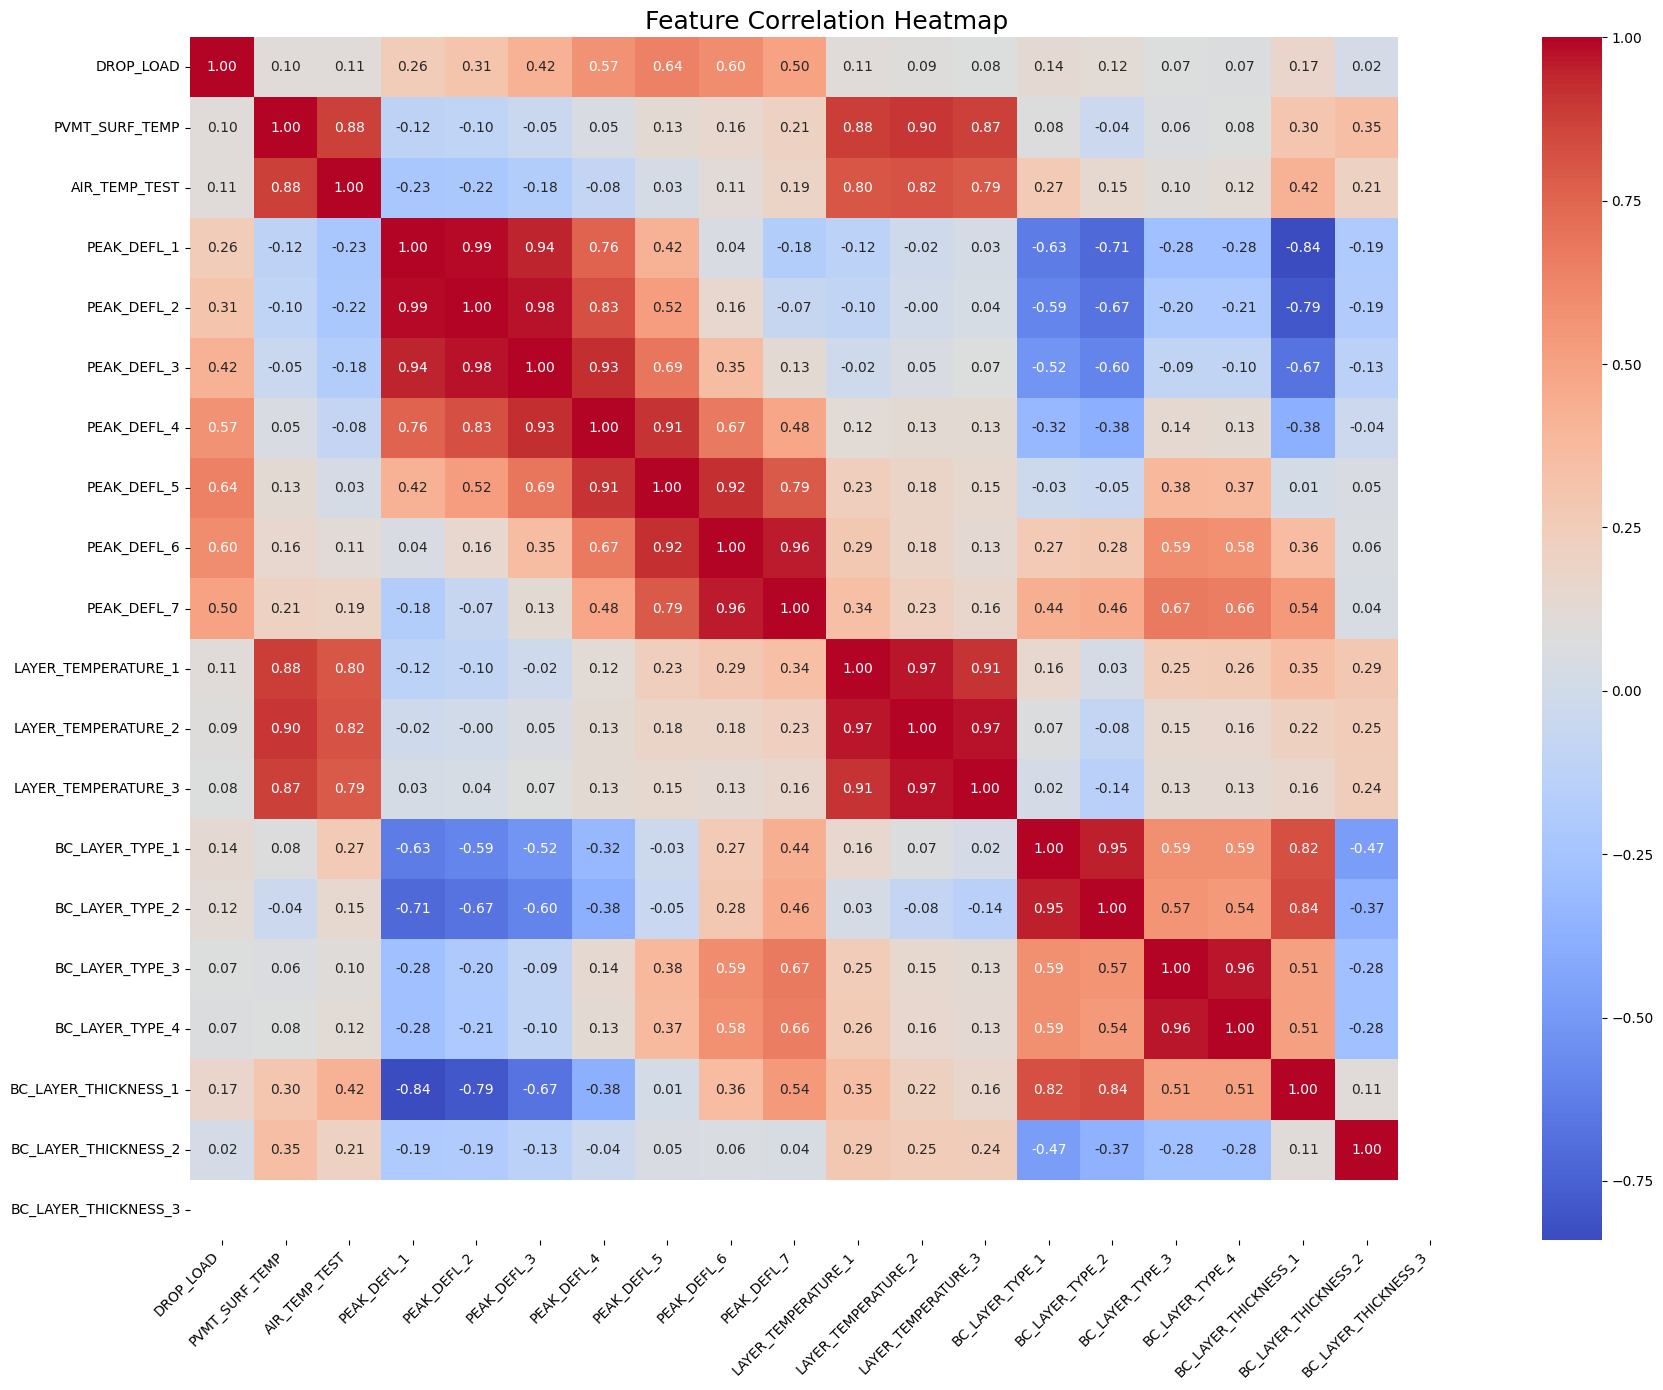


🌟 SHAP解释 -> MODULUS_1
MAE: 0.0002
MSE: 0.0000
R²: 1.0000


100%|===================| 1951/1958 [00:32<00:00]       

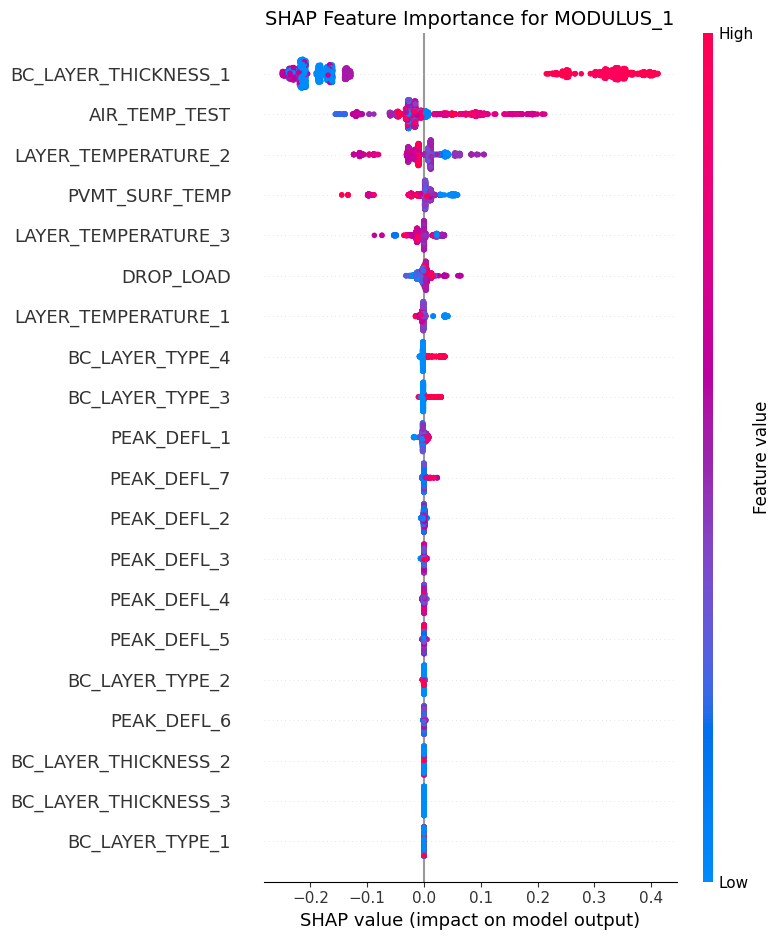


🌟 SHAP解释 -> MODULUS_2
MAE: 0.0001
MSE: 0.0000
R²: 0.9999


 98%|===================| 1910/1958 [00:35<00:00]       

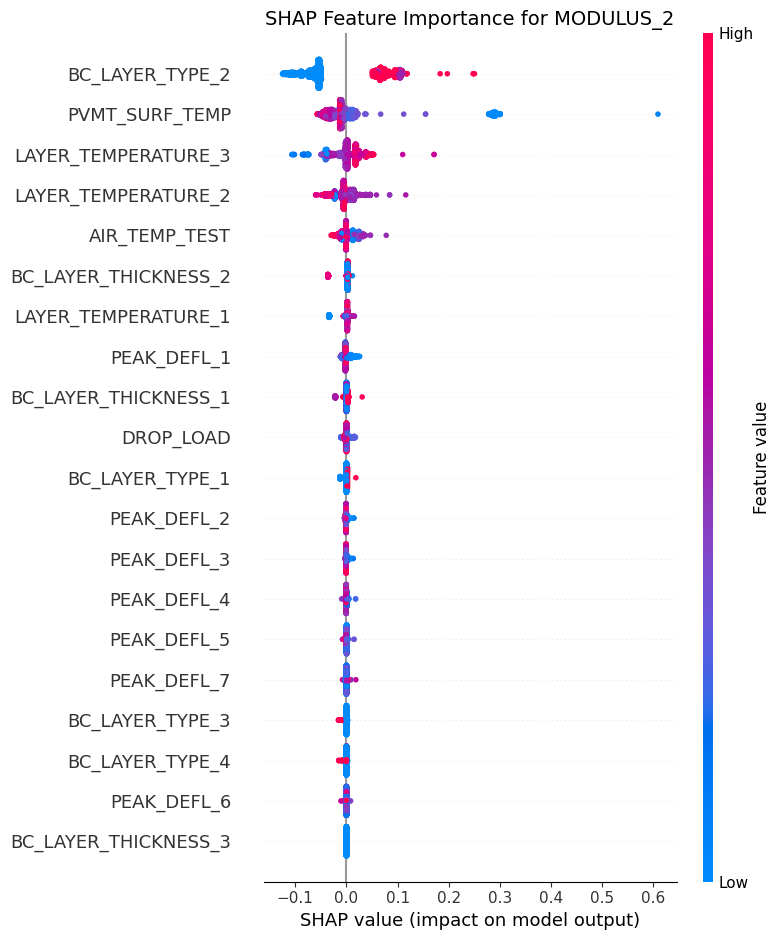


🌟 SHAP解释 -> MODULUS_3
MAE: 0.0010
MSE: 0.0001
R²: 0.9968


100%|===================| 1956/1958 [00:36<00:00]       

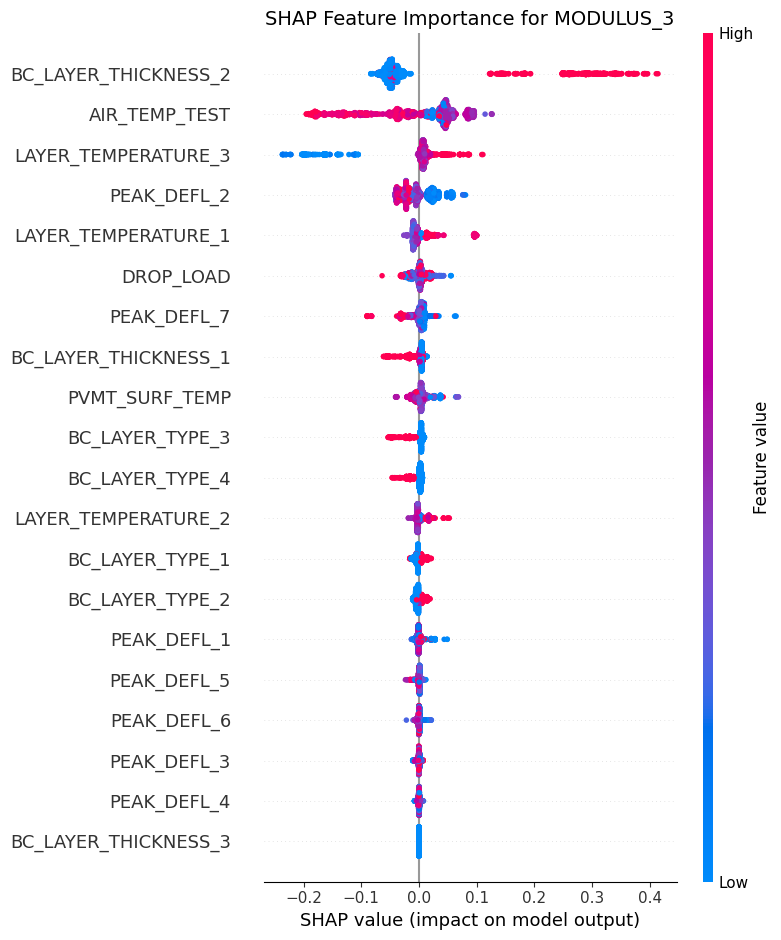


🌟 SHAP解释 -> MODULUS_4
MAE: 0.0000
MSE: 0.0000
R²: 1.0000


 96%|=================== | 1889/1958 [00:28<00:01]       

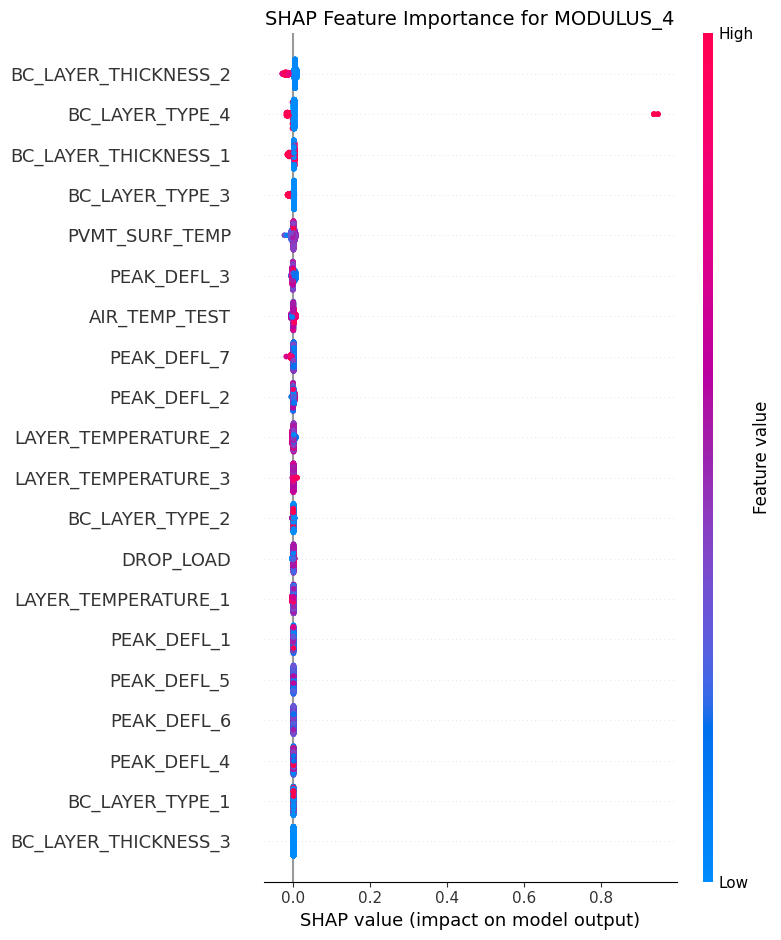

In [ ]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. 读取数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/九千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# === 2. 修改后的特征列与目标列 ===
selected_features = [
    'DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3'
]
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X = df[selected_features].copy()
y = df[target_columns].copy()

# === 3. 缺失值处理 ===
continuous_features = [
    'DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3'
]
categorical_features = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']

for col in continuous_features:
    X[col] = X[col].fillna(X[col].mean())
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])
y = y.fillna(y.mean())

# === 4. 编码分类特征 ===
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# === 📊 热力图 ===
plt.figure(figsize=(18, 14))
corr_matrix = X[selected_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# === 5. 标准化 ===
feature_names = X.columns.tolist()

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# === 6. 数据划分 ===
X_train, X_test, y_train_all, y_test_all = train_test_split(X_scaled, y_scaled, test_size=0.2)

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# === 7. SHAP 分析（针对每个 MODULUS） ===
for i, target in enumerate(target_columns):
    print(f"\n🌟 SHAP解释 -> {target}")
    y_train = y_train_all[:, i]
    y_test = y_test_all[:, i]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_df, y_train)

    y_pred = rf.predict(X_test_df)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")

    explainer = shap.Explainer(rf, X_train_df)
    shap_values = explainer(X_test_df)

    # === 全特征显示，取消Sum of others ===
    shap.plots.beeswarm(shap_values, max_display=len(feature_names), show=False)
    plt.title(f"SHAP Feature Importance for {target}", fontsize=14)
    plt.tight_layout()
    plt.show()



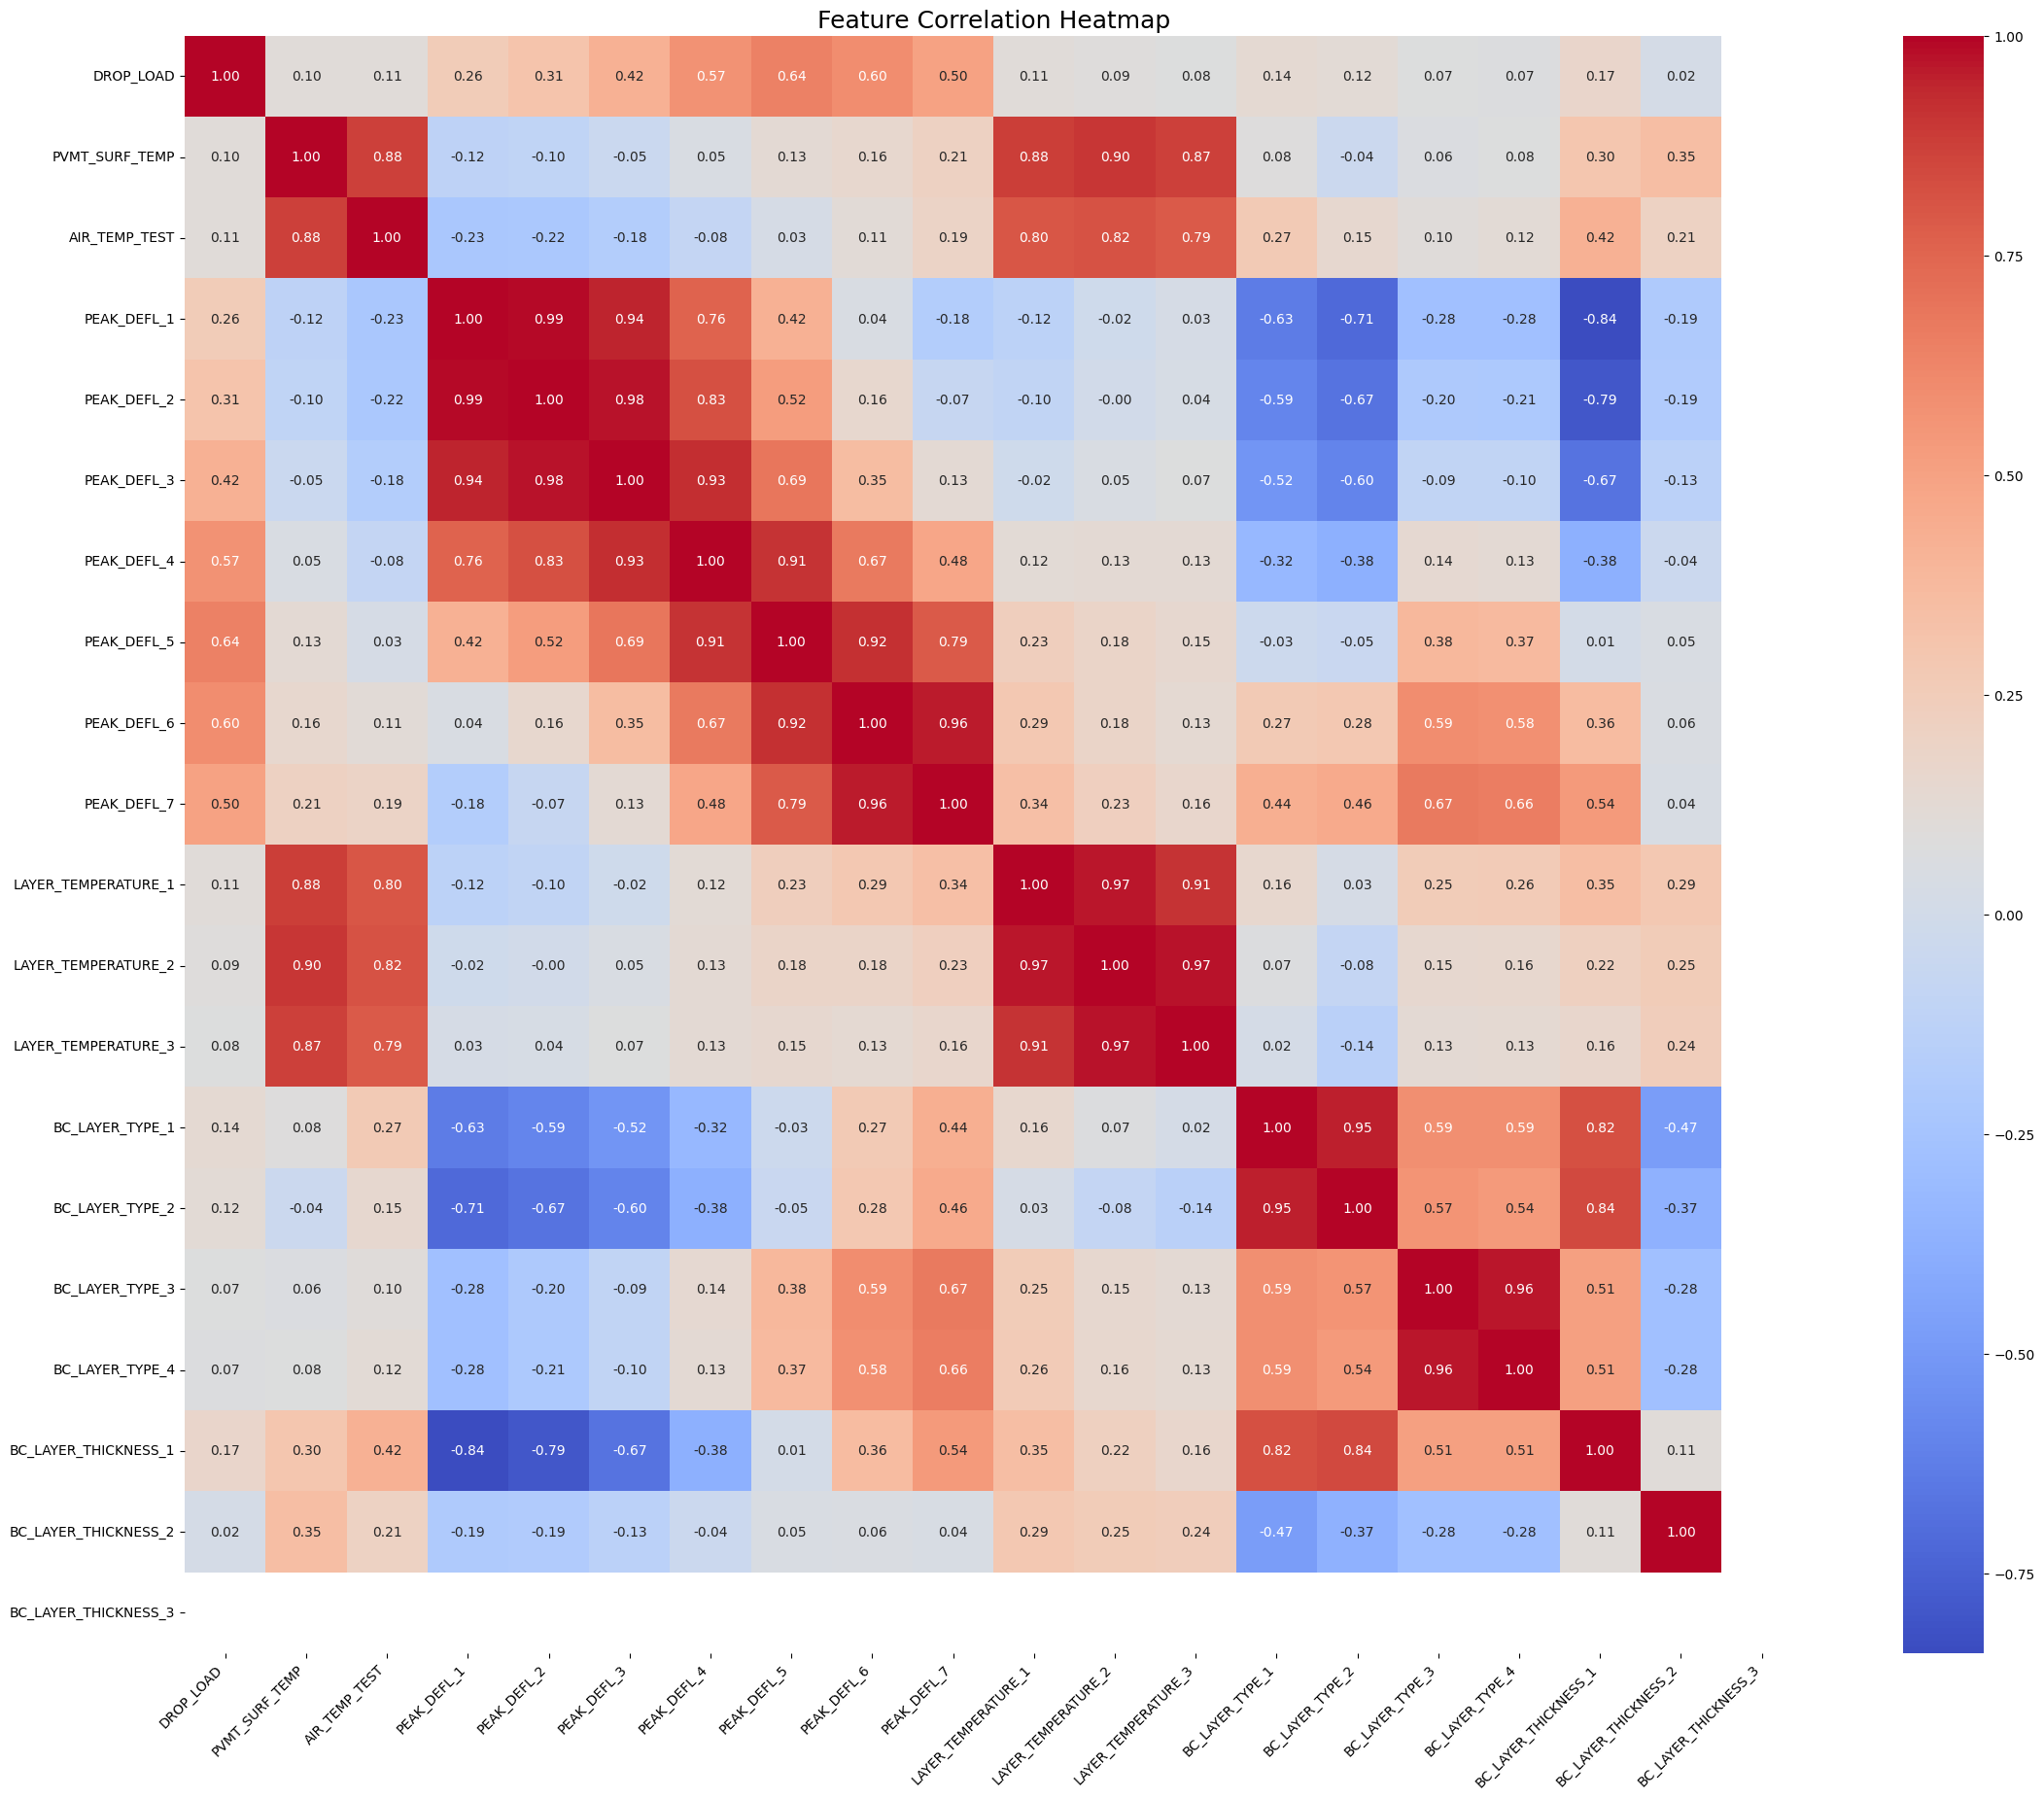

✅ 相关性矩阵维度: (20, 20)

🌟 SHAP解释 -> MODULUS_1
MAE: 0.0003
MSE: 0.0000
R²: 0.9999


 98%|===================| 1919/1958 [00:29<00:00]       

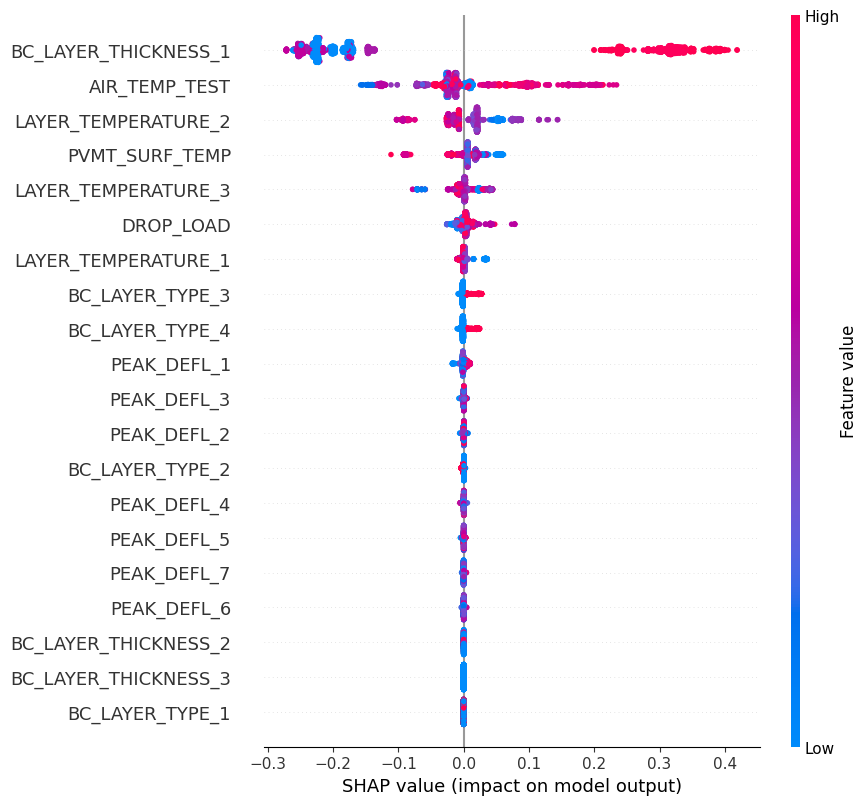


🌟 SHAP解释 -> MODULUS_2
MAE: 0.0002
MSE: 0.0000
R²: 0.9998


 98%|===================| 1918/1958 [00:35<00:00]       

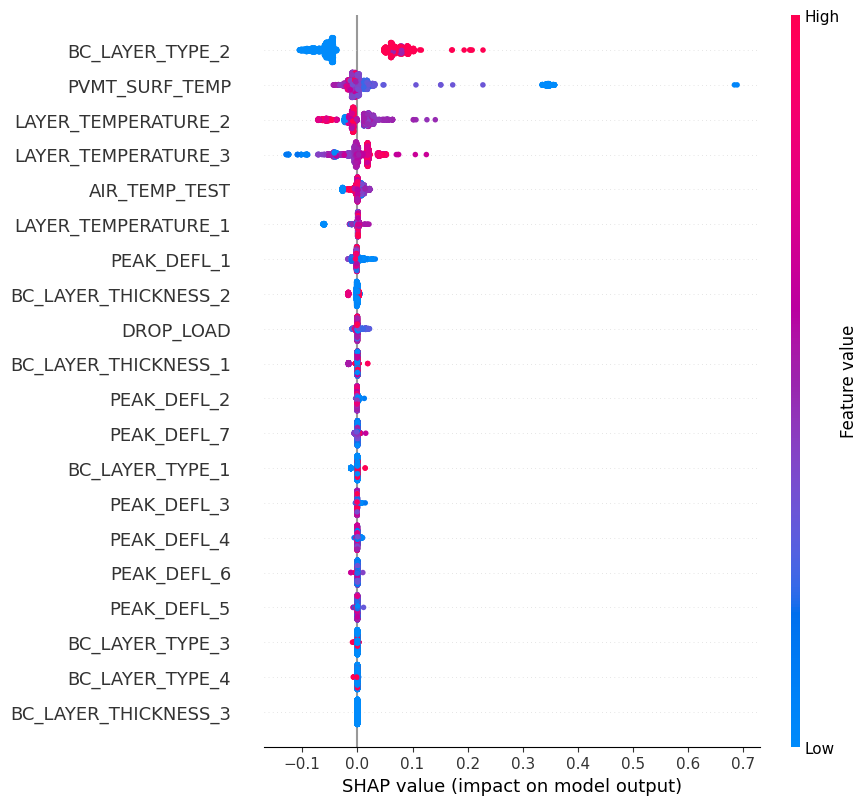


🌟 SHAP解释 -> MODULUS_3
MAE: 0.0011
MSE: 0.0002
R²: 0.9938


 98%|===================| 1910/1958 [00:36<00:00]       

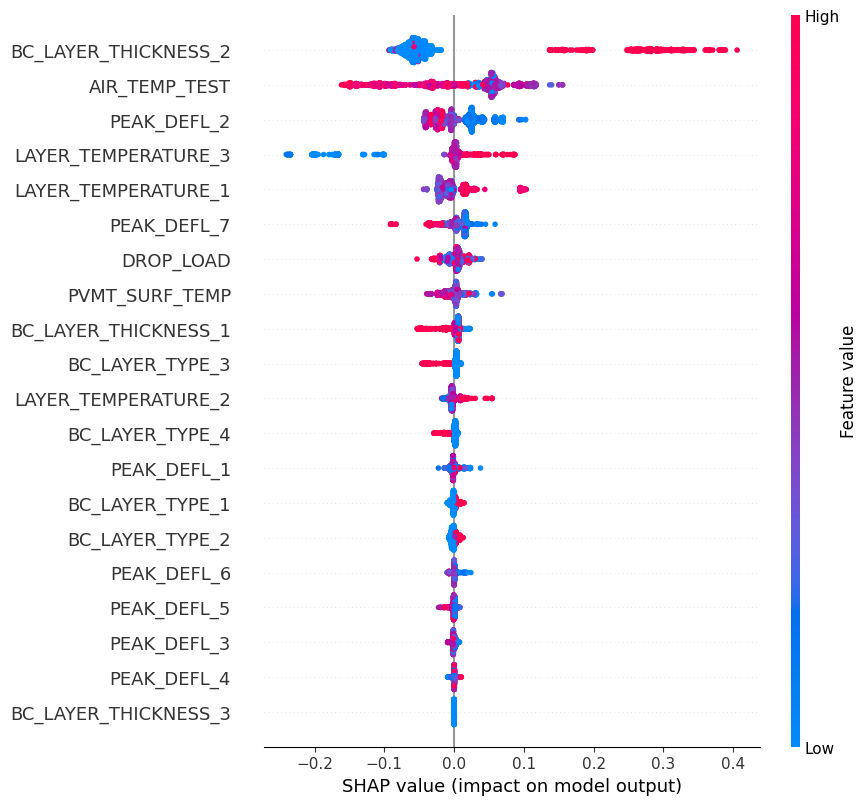


🌟 SHAP解释 -> MODULUS_4
MAE: 0.0001
MSE: 0.0000
R²: 0.9999


 98%|===================| 1915/1958 [00:29<00:00]       

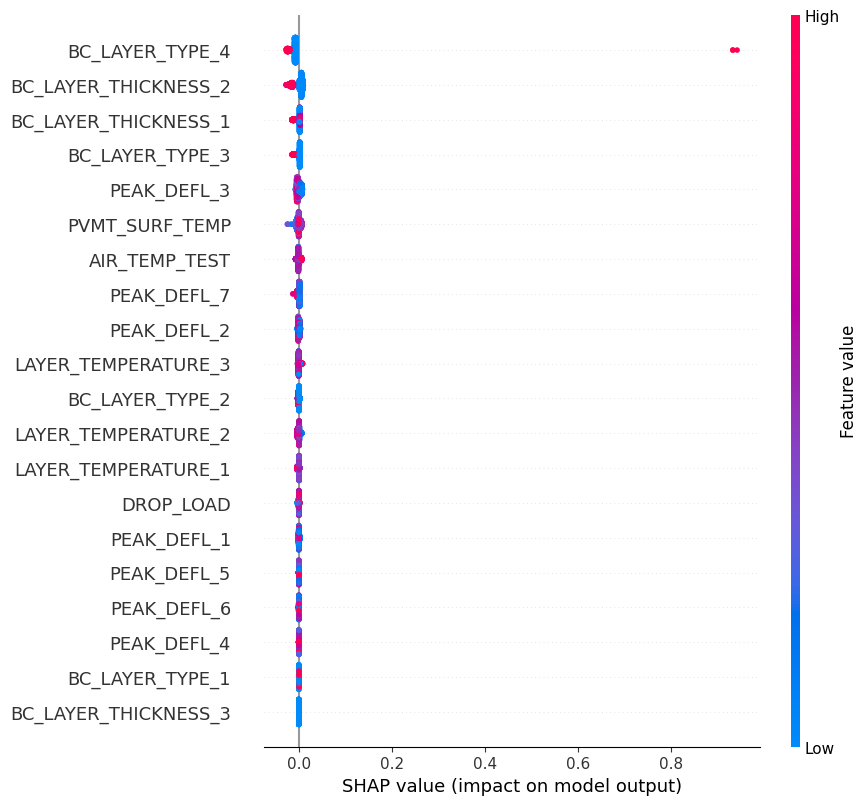

In [ ]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === 1. 读取数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/九千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# === 2. 特征列与目标列 ===
selected_features = [
    'DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3'
]
target_columns = ['MODULUS_1', 'MODULUS_2', 'MODULUS_3', 'MODULUS_4']

X = df[selected_features].copy()
y = df[target_columns].copy()

# === 3. 清洗列名防止错位 ===
X.columns = X.columns.str.strip()
selected_features = [col.strip() for col in selected_features]

# === 4. 缺失值处理 ===
continuous_features = [
    'DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3'
]
categorical_features = ['BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4']

for col in continuous_features:
    X[col] = X[col].fillna(X[col].mean())
for col in categorical_features:
    X[col] = X[col].fillna(X[col].mode()[0])
y = y.fillna(y.mean())

# === 5. 编码分类特征 ===
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# === 6. 热力图（修复一行一列丢失） ===
corr_matrix = X[selected_features].corr()

fig, ax = plt.subplots(figsize=(26, 26))  # 大画布
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 10},
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)
ax.set_title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# （可选）打印维度确认完整
print("✅ 相关性矩阵维度:", corr_matrix.shape)  # 应为 (20, 20)

# === 7. 标准化 ===
feature_names = X.columns.tolist()
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# === 8. 数据划分 ===
X_train, X_test, y_train_all, y_test_all = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# === 9. SHAP 分析（逐个 MODULUS） ===
for i, target in enumerate(target_columns):
    print(f"\n🌟 SHAP解释 -> {target}")
    y_train = y_train_all[:, i]
    y_test = y_test_all[:, i]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_df, y_train)

    y_pred = rf.predict(X_test_df)
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"R²: {r2_score(y_test, y_pred):.4f}")

    explainer = shap.Explainer(rf, X_train_df)
    shap_values = explainer(X_test_df, check_additivity=False)

    # === SHAP 图为正方形 + 不加标题 ===
    plt.figure(figsize=(10, 10))
    shap.plots.beeswarm(shap_values, max_display=len(feature_names), show=False)
    plt.show()


⚠️ 以下列因无有效方差被排除: ['BC_LAYER_THICKNESS_3']
✅ 相关性矩阵维度: (19, 19)


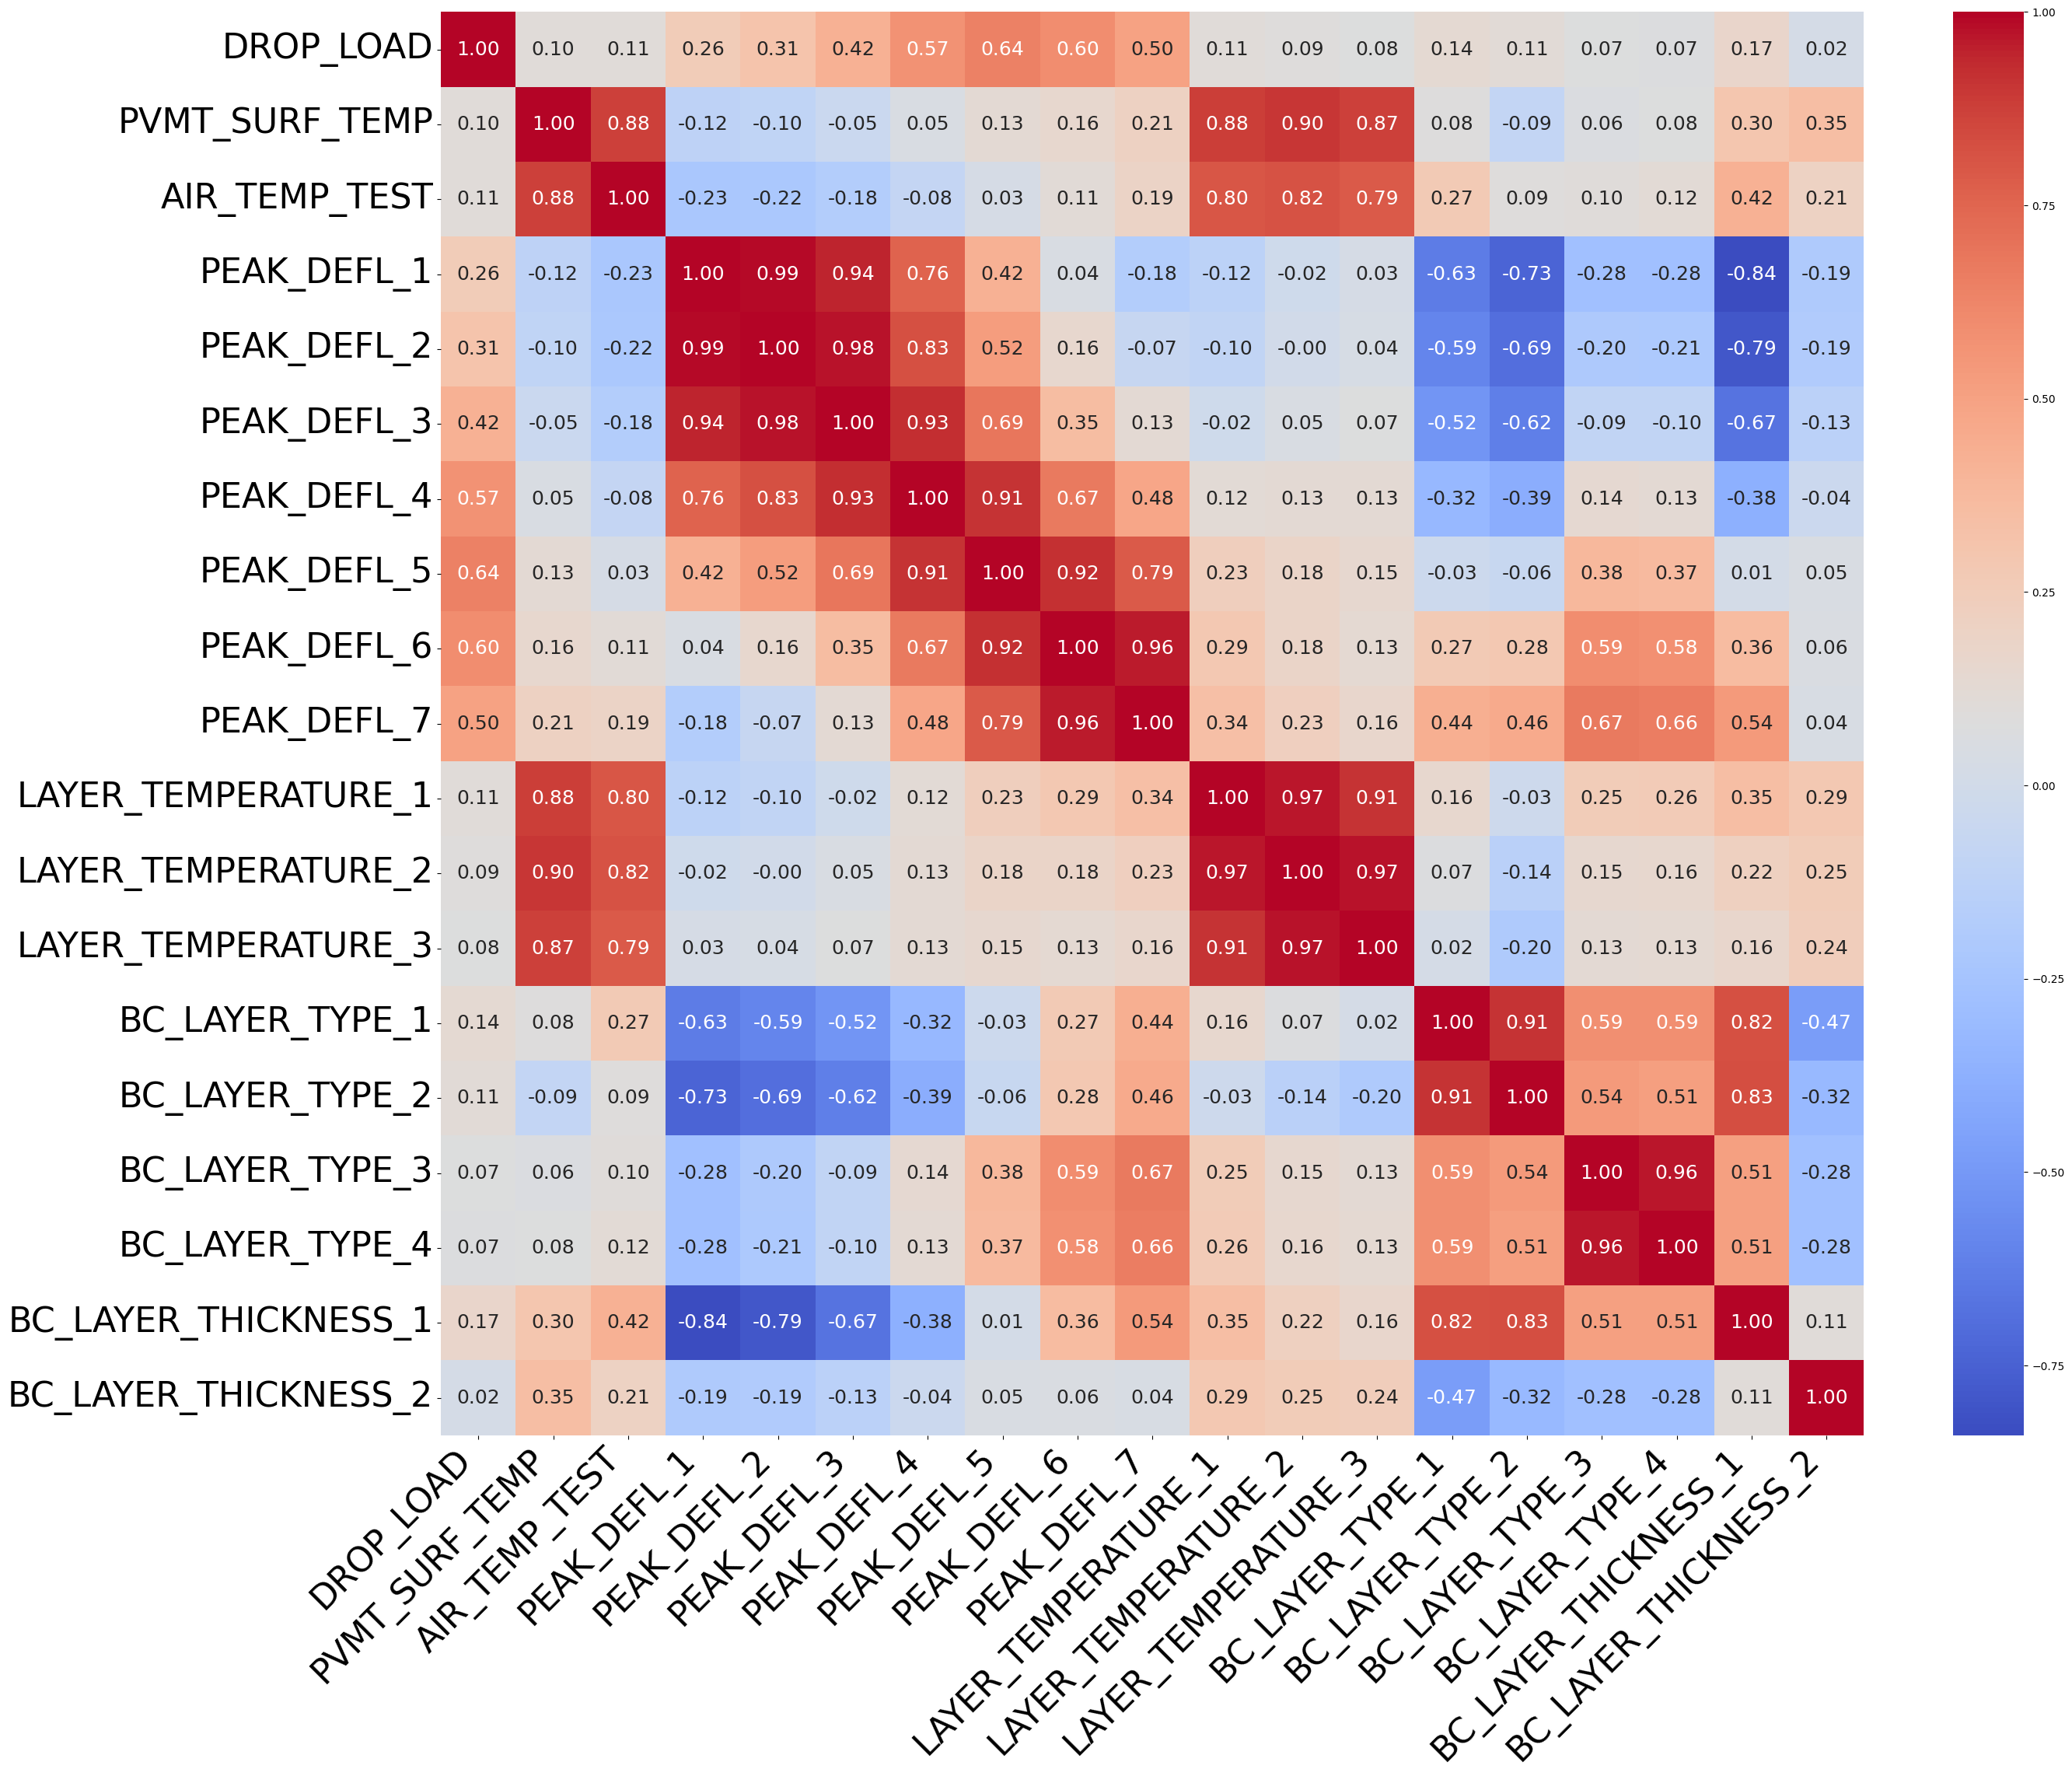

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 读取数据 ===
file_path = "/content/drive/MyDrive/Colab Notebooks/LTPP/文件/九千条数据.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1", header=0)

# === 2. 手动指定特征列（如你原始设置）===
selected_features = [
    'DROP_LOAD', 'PVMT_SURF_TEMP', 'AIR_TEMP_TEST',
    'PEAK_DEFL_1', 'PEAK_DEFL_2', 'PEAK_DEFL_3', 'PEAK_DEFL_4',
    'PEAK_DEFL_5', 'PEAK_DEFL_6', 'PEAK_DEFL_7',
    'LAYER_TEMPERATURE_1', 'LAYER_TEMPERATURE_2', 'LAYER_TEMPERATURE_3',
    'BC_LAYER_TYPE_1', 'BC_LAYER_TYPE_2', 'BC_LAYER_TYPE_3', 'BC_LAYER_TYPE_4',
    'BC_LAYER_THICKNESS_1', 'BC_LAYER_THICKNESS_2', 'BC_LAYER_THICKNESS_3'
]

X = df[selected_features].copy()
X.columns = X.columns.str.strip()

# === 3. 自动剔除常数列 ===
valid_cols = X.loc[:, X.nunique() > 1].columns
excluded_cols = list(set(X.columns) - set(valid_cols))
print("⚠️ 以下列因无有效方差被排除:", excluded_cols)

# === 4. 计算相关性矩阵 ===
corr_matrix = X[valid_cols].corr()
print("✅ 相关性矩阵维度:", corr_matrix.shape)

# === 5. 绘制热力图 ===
fig, ax = plt.subplots(figsize=(26, 26))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 18},
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
fig.subplots_adjust(left=0.12, right=1, top=1, bottom=0.12)
plt.xticks(rotation=45, ha="right", fontsize=32)
plt.yticks(rotation=0, fontsize=32)
plt.show()


In [ ]:
col = 'BC_LAYER_THICKNESS_2'
print(f"\n✅ {col} 基本统计：")
print(X[col].describe())
print("是否常数列：", X[col].nunique() == 1)
print("是否全为 NaN：", X[col].isnull().all())



✅ BC_LAYER_THICKNESS_2 基本统计：
count    9788.000000
mean      183.245781
std        40.059205
min       157.500000
25%       157.500000
50%       160.000000
75%       233.700000
max       254.000000
Name: BC_LAYER_THICKNESS_2, dtype: float64
是否常数列： False
是否全为 NaN： False
